# Fase 1: Analisi degli obiettivi e raccolta dati

1. Definizione dello scopo del progetto

Obiettivo generale:
 
Costruire un sistema RAG (Retrieval-Augmented Generation) capace di rispondere a domande complesse sulla documentazione non finanziaria relativa a criteri ESG, integrando fonti e Knowledge Graphs.


# Fase 2: accesso e parsing dati ESG

Fase 2 – Step-by-step

Step	Obiettivo	Tecnologie

2.1	| Download di un dataset ESG dal World Bank Portal | pandas, requests

2.2	| Esplorazione iniziale e pulizia del dataset |	pandas, numpy

2.3	| Tokenizzazione e suddivisione in chunk | nltk, transformers

2.4	| Embedding dei chunk |	sentence-transformers, HuggingFace

2.5	| Salvataggio su vector DB | (FAISS, Qdrant, ecc.)	

In [1]:
!pip install pycountry_convert > /dev/null 2>&1
import pycountry_convert as pc

In [2]:
!pip install rouge-score > /dev/null 2>&1

In [3]:
#!pip install pycountry_convert > /dev/null 2>&1
!pip install faiss-cpu > /dev/null 2>&1
!pip install -q transformers accelerate > /dev/null 2>&1
!pip install -q langchain faiss-cpu > /dev/null 2>&1
!pip install -U langchain-community > /dev/null 2>&1
!pip install -q rdflib > /dev/null 2>&1
!pip install pyvis > /dev/null 2>&1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#import pycountry_convert as pc
import faiss
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from rdflib import Graph, Namespace, Literal, URIRef
from rdflib.namespace import RDF, RDFS, XSD
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.llms import HuggingFacePipeline
from langchain.schema import Document
from langchain.chains import RetrievalQAWithSourcesChain
from pyvis.network import Network
from rdflib.plugins.sparql import prepareQuery
import re
from difflib import get_close_matches

## 2.1 | Download di un dataset ESG dal World Bank Portal

Dopo aver scaricato i dati, li carico sul notebook.

In [4]:
df_dati = pd.read_csv("/kaggle/input/api-data/Data.csv")
print("Dati ESG:")
print(df_dati.head())
print(df_dati.columns)

df_meta = pd.read_csv(
    "/kaggle/input/metadata/Series - Metadata.csv",
    encoding='cp1252',
    on_bad_lines='skip'
)
print("\n Metadati indicatori:")
print(df_meta.head())
print(df_meta.columns)

📊 Dati ESG:
                                         Series Name     Series Code  \
0  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.ZS   
1  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.ZS   
2  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.ZS   
3  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.ZS   
4  Access to clean fuels and technologies for coo...  EG.CFT.ACCS.ZS   

  Country Name Country Code 2010 [YR2010] 2011 [YR2011] 2012 [YR2012]  \
0  Afghanistan          AFG          19.7          21.3          22.7   
1      Albania          ALB          65.8          68.1          70.4   
2      Algeria          DZA          99.2          99.3          99.4   
3      Andorra          AND           100           100           100   
4       Angola          AGO          44.7          45.2          45.8   

  2013 [YR2013] 2014 [YR2014] 2015 [YR2015] 2016 [YR2016] 2017 [YR2017]  \
0          24.3          25.7         27.

## 2.2 | Esplorazione iniziale e pulizia del dataset

In questa fase andremo a:

1. Sostituire i valori .. con NaN e convertire i dati in numerici.

2. Conversione delle colonne in float

2. Analizzare la quantità di dati mancanti.

3. Scegliere un sottoinsieme di indicatori per testare l’architettura RAG.

4. Trasformare il formato da wide a long per il vector DB.

In [5]:
df = df_dati.copy()

# STEP 1: Sostituzione dei valori '..' con NaN
df.replace("..", np.nan, inplace=True)

In [6]:
# STEP 2: Conversione delle colonne temporali in float
year_cols = [col for col in df.columns if col.startswith("20")]
df[year_cols] = df[year_cols].apply(pd.to_numeric, errors='coerce')

In [7]:
# STEP 3: Report iniziale sulla qualità del dataset
print(f"Numero totale di indicatori unici: {df['Series Name'].nunique()}")
print(f"Numero totale di paesi: {df['Country Name'].nunique()}")

missing_by_year = df[year_cols].isna().mean().round(3) * 100
print("\n📉 Percentuale di valori mancanti per anno:")
print(missing_by_year)

🔢 Numero totale di indicatori unici: 73
🌍 Numero totale di paesi: 205

📉 Percentuale di valori mancanti per anno:
2010 [YR2010]    24.8
2011 [YR2011]    25.9
2012 [YR2012]    25.2
2013 [YR2013]    24.2
2014 [YR2014]    23.8
2015 [YR2015]    24.5
2016 [YR2016]    27.9
2017 [YR2017]    29.1
2018 [YR2018]    28.3
2019 [YR2019]    30.2
2020 [YR2020]    34.3
2021 [YR2021]    55.6
2022 [YR2022]    77.3
2023 [YR2023]    97.4
dtype: float64


In [8]:
# STEP 4: Verifica un esempio di un indicatore
sample_indicator = df[df["Series Code"] == df["Series Code"].unique()[0]]
display(sample_indicator.head())

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Series Name,Series Code,Country Name,Country Code,2010 [YR2010],2011 [YR2011],2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Afghanistan,AFG,19.7,21.3,22.7,24.3,25.7,27.25,28.5,30.0,31.1,32.45,33.8,35.4,NaN,NaN
1,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Albania,ALB,65.8,68.1,70.4,72.3,74.4,76.10,77.6,79.0,80.2,81.60,82.7,83.7,NaN,NaN
2,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Algeria,DZA,99.2,99.3,99.4,99.4,99.5,99.60,99.6,99.6,99.6,99.70,99.7,99.7,NaN,NaN
3,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Andorra,AND,100.0,100.0,100.0,100.0,100.0,100.00,100.0,100.0,100.0,100.00,100.0,100.0,NaN,NaN
4,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Angola,AGO,44.7,45.2,45.8,46.1,46.7,47.40,47.8,48.3,48.7,49.30,49.7,50.0,NaN,NaN


In [9]:
# STEP 5: Trasformazione in formato long, pd.melt mi fa unire le varie colonne per gli anni in una unica
df_long = df.melt(
    id_vars=["Series Name", "Series Code", "Country Name", "Country Code"],
    value_vars=year_cols,
    var_name="Year",
    value_name="Value"
)

# Rimuove i valori mancanti
df_long.dropna(subset=["Value"], inplace=True)

df_long["Year"] = df_long["Year"].str.extract(r"(\d{4})").astype(int)

print("\n📄 Dataset in formato long (primi 5 record):")
display(df_long.head())


📄 Dataset in formato long (primi 5 record):


,Series Name,Series Code,Country Name,Country Code,Year,Value
0,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Afghanistan,AFG,2010,19.7
1,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Albania,ALB,2010,65.8
2,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Algeria,DZA,2010,99.2
3,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Andorra,AND,2010,100.0
4,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,Angola,AGO,2010,44.7


In [10]:
year_counts = df_long.groupby("Year")["Value"].count()
print(year_counts)

Year
2010    10955
2011    10787
2012    10898
2013    11036
2014    11101
2015    10990
2016    10498
2017    10322
2018    10446
2019    10169
2020     9571
2021     6471
2022     3312
2023      385
Name: Value, dtype: int64


Possiamo vedere che dopo aver eliminato i dati mancanti dal 2021 in poi abbiamo pochi valori rispetto agli anni precedenti, quindi manteniamo i dati fino al 2021

In [11]:
print("Numero totale di record prima del filtro:", len(df_long))

df_long = df_long[df_long["Year"] <= 2020].copy()

df_long.reset_index(drop=True, inplace=True)

print("Numero totale di record dopo il filtro:", len(df_long))
print("Anni rimanenti:", df_long["Year"].unique())

🧮 Numero totale di record prima del filtro: 126941
🧮 Numero totale di record dopo il filtro: 116773
✅ Anni rimanenti: [2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]


Ora vediamo alcune analisi esplorative

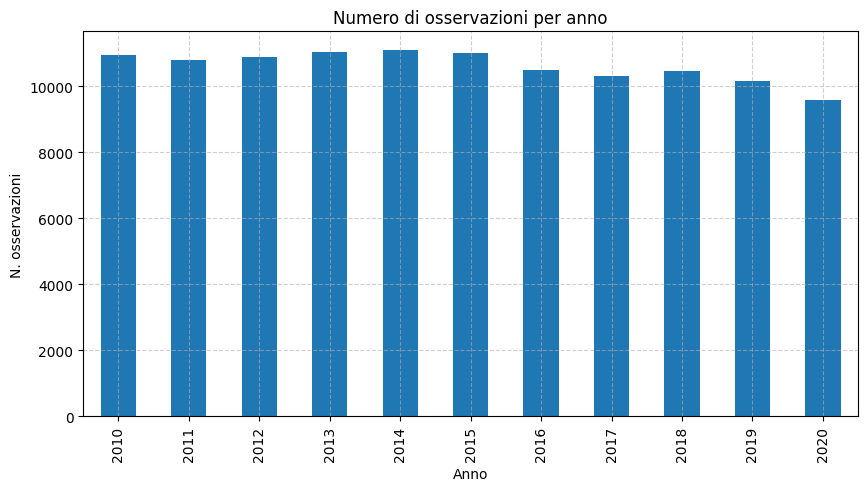

In [12]:
# 1. Distribuzione delle osservazioni per anno

year_counts = df_long["Year"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
year_counts.plot(kind='bar')
plt.title("Numero di osservazioni per anno")
plt.xlabel("Anno")
plt.ylabel("N. osservazioni")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

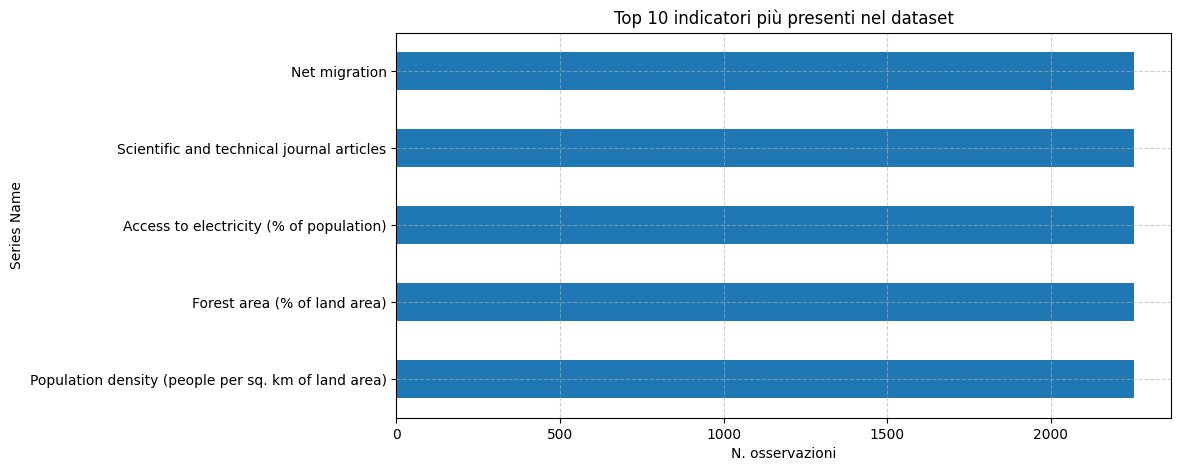

In [13]:
# 2. Indicatori con il maggior numero di osservazioni

indicator_counts = df_long["Series Name"].value_counts().head(5)

plt.figure(figsize=(10, 5))
indicator_counts.plot(kind='barh')
plt.title("Top 10 indicatori più presenti nel dataset")
plt.xlabel("N. osservazioni")
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

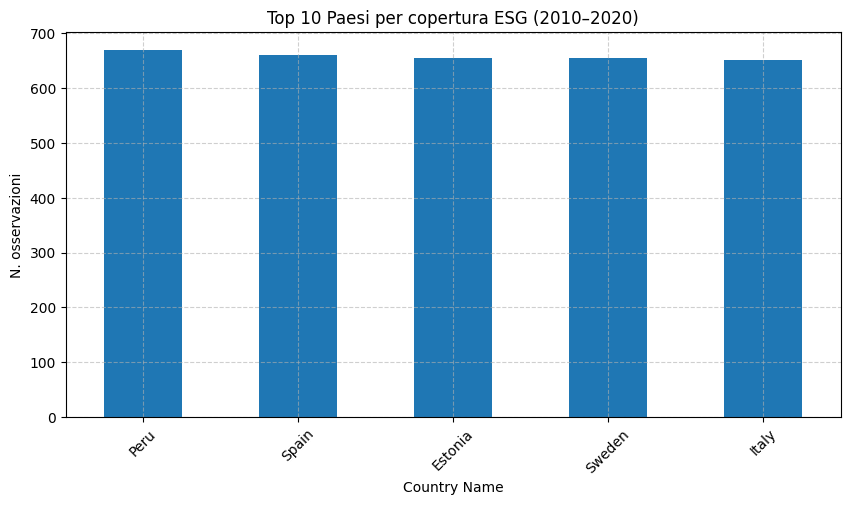

In [14]:
# 3. Paesi con la copertura ESG più completa

coverage_by_country = df_long.groupby("Country Name")["Value"].count().sort_values(ascending=False).head(5)

plt.figure(figsize=(10, 5))
coverage_by_country.plot(kind='bar')
plt.title("Top 10 Paesi per copertura ESG (2010–2020)")
plt.ylabel("N. osservazioni")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.show()

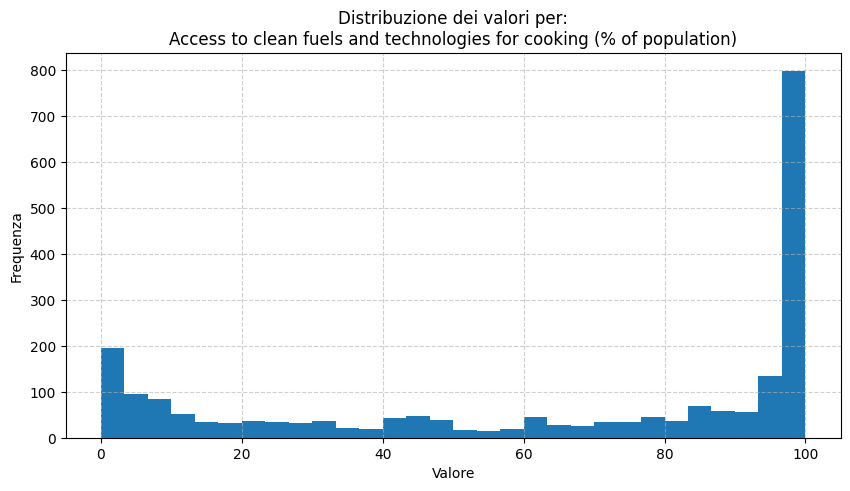

In [15]:
# 4. Distribuzione dei valori per un indicatore a scelta (es. GHG o accesso a energia pulita)

indicatore_target = "Access to clean fuels and technologies for cooking (% of population)"

subset = df_long[df_long["Series Name"] == indicatore_target]

plt.figure(figsize=(10, 5))
subset["Value"].hist(bins=30)
plt.title(f"Distribuzione dei valori per:\n{indicatore_target}")
plt.xlabel("Valore")
plt.ylabel("Frequenza")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

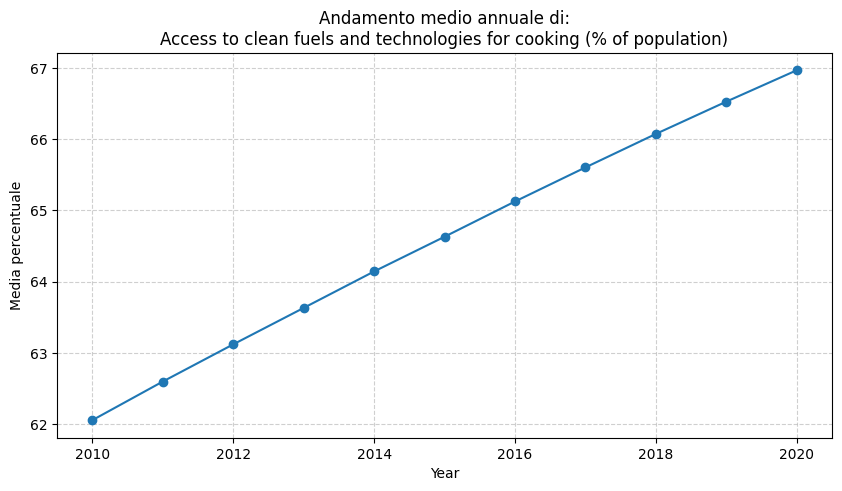

In [16]:
media_annua = subset.groupby("Year")["Value"].mean()

plt.figure(figsize=(10, 5))
media_annua.plot(marker='o')
plt.title(f"Andamento medio annuale di:\n{indicatore_target}")
plt.ylabel("Media percentuale")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


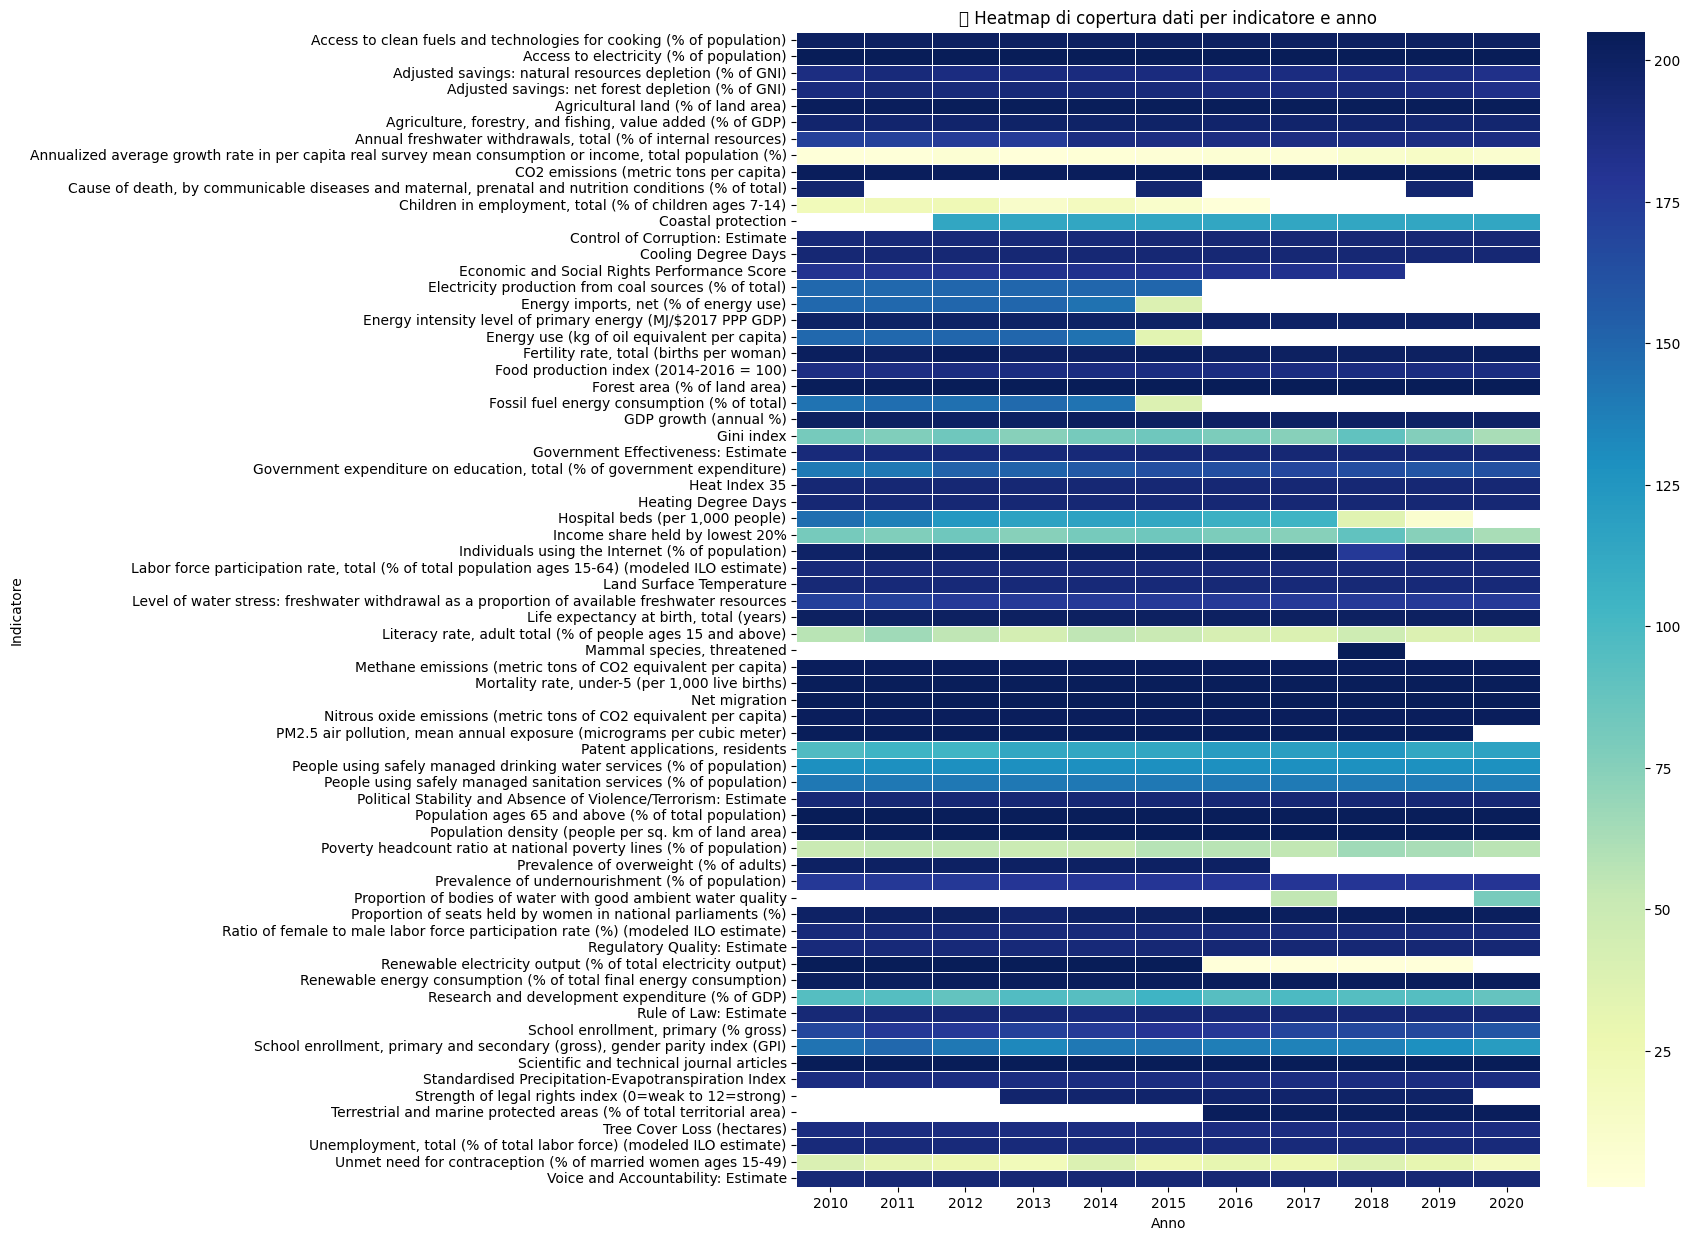

In [17]:
# 1. Heatmap di copertura per indicatori e anni

coverage_matrix = df_long.pivot_table(index="Series Name", columns="Year", values="Value", aggfunc='count')

plt.figure(figsize=(12, 15))
sns.heatmap(coverage_matrix, cmap="YlGnBu", linewidths=0.5, annot=False)
plt.title("📊 Heatmap di copertura dati per indicatore e anno")
plt.xlabel("Anno")
plt.ylabel("Indicatore")
plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


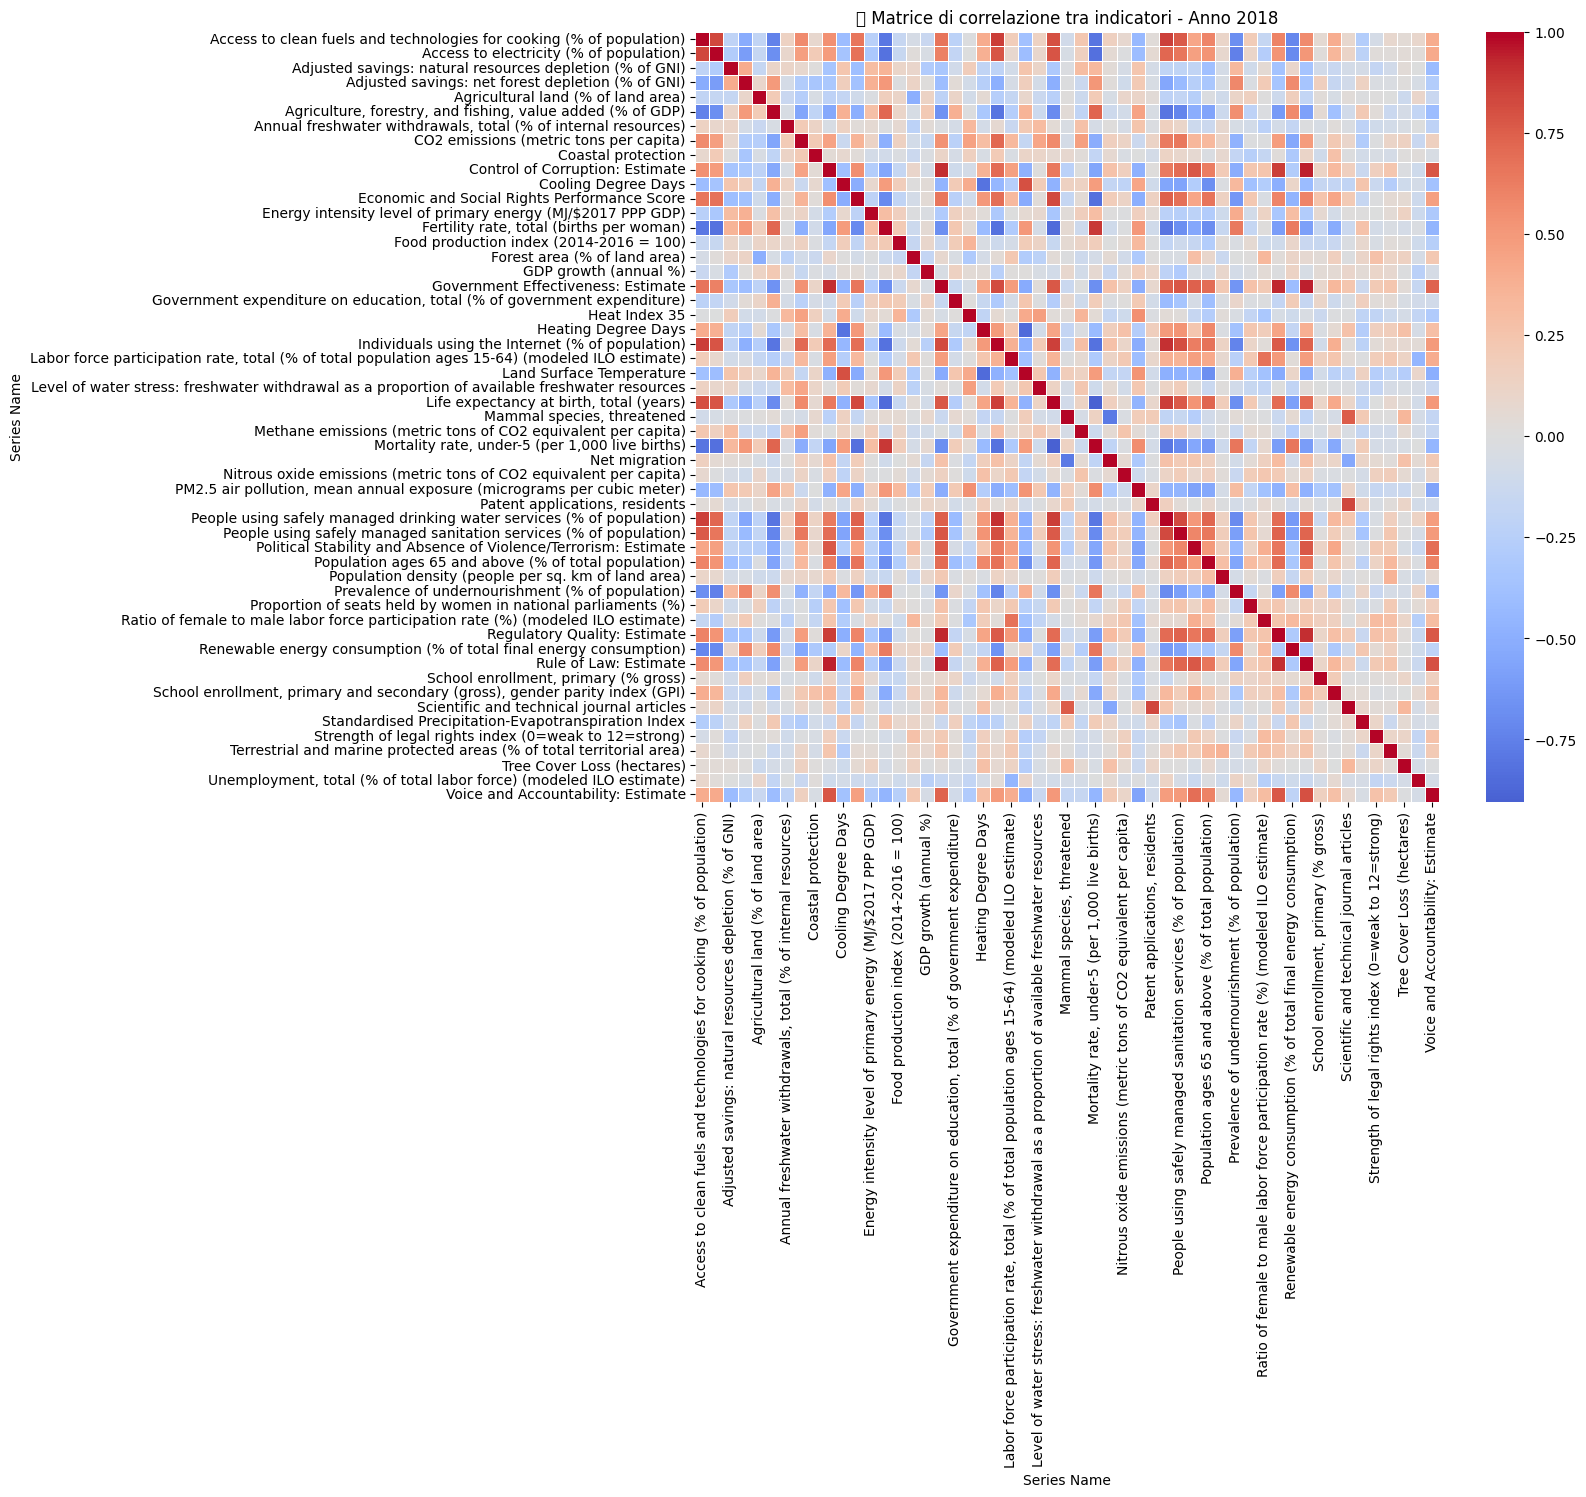

In [18]:
# 2. Matrice di correlazione tra indicatori (per anno fisso)
anno_focus = 2018
df_corr = df_long[df_long["Year"] == anno_focus].pivot_table(
    index="Country Name", columns="Series Name", values="Value"
)
df_corr = df_corr.dropna(thresh=int(0.5 * df_corr.shape[0]), axis=1)
corr_matrix = df_corr.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title(f"Matrice di correlazione tra indicatori - Anno {anno_focus}")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-19-339e779a74d6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Cluster'] = kmeans.fit_predict(X_scaled)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


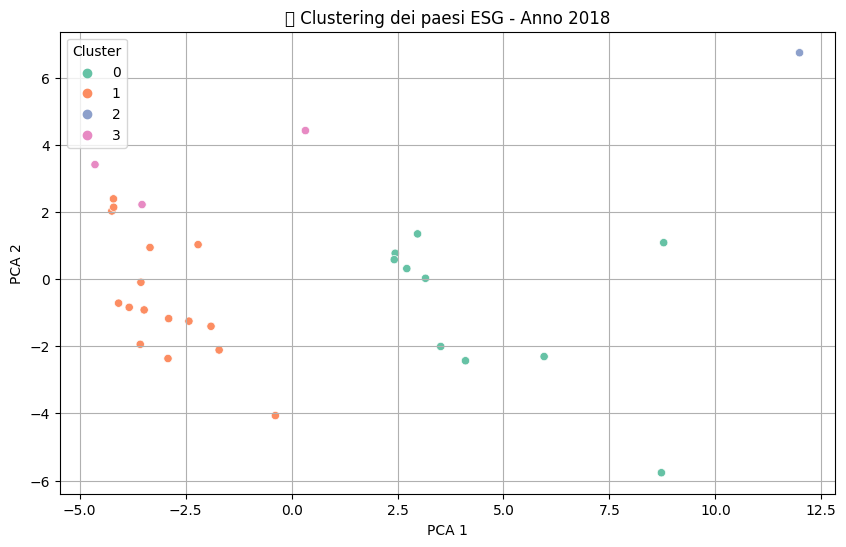

In [19]:
# 3. Clustering dei paesi sulla base degli indicatori
X = df_corr.dropna()
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
X['Cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=X['Cluster'], palette='Set2')
plt.title(f"Clustering dei paesi ESG - Anno {anno_focus}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

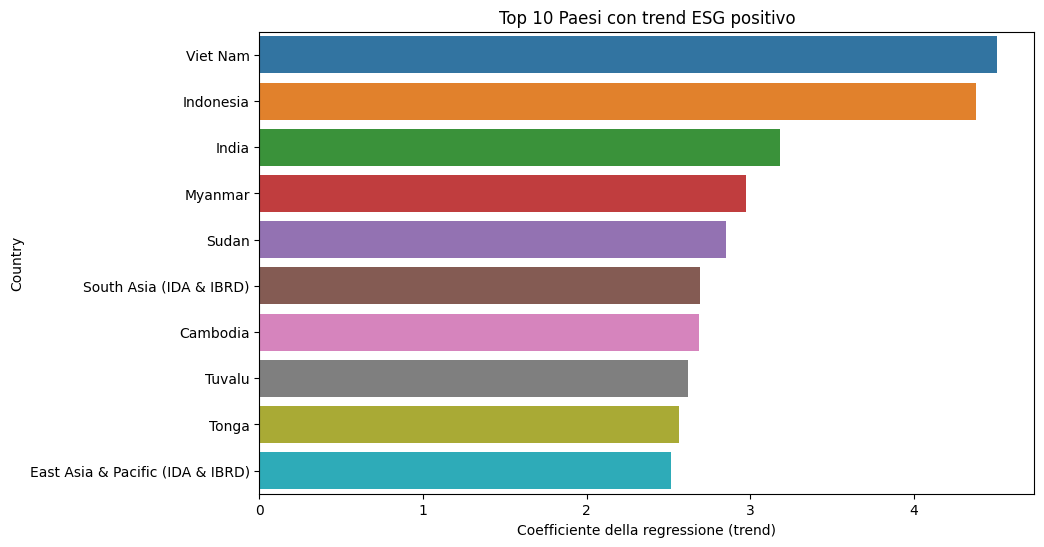

In [20]:
# 4. Analisi delle tendenze longitudinali (regressione lineare)

from sklearn.linear_model import LinearRegression

indicatore = "Access to clean fuels and technologies for cooking (% of population)"
df_i = df_long[df_long["Series Name"] == indicatore].dropna()

trend_data = []

for country in df_i["Country Name"].unique():
    sub = df_i[df_i["Country Name"] == country]
    if len(sub) >= 5:  
        X = sub[["Year"]]
        y = sub["Value"]
        model = LinearRegression().fit(X, y)
        trend_data.append((country, model.coef_[0]))

trend_df = pd.DataFrame(trend_data, columns=["Country", "Trend"])
trend_df = trend_df.sort_values("Trend", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Trend", y="Country", data=trend_df.head(10))
plt.title("Top 10 Paesi con trend ESG positivo")
plt.xlabel("Coefficiente della regressione (trend)")
plt.show()

Creiamo la variabile continente

In [21]:
def country_to_continent(country_name):
    try:
        country_code = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = {
            'AF': 'Africa',
            'AS': 'Asia',
            'EU': 'Europe',
            'NA': 'North America',
            'SA': 'South America',
            'OC': 'Oceania',
            'AN': 'Antarctica'
        }
        return continent_name[continent_code]
    except:
        return "Unknown"

df_long["Continent"] = df_long["Country Name"].apply(country_to_continent)

print(df_long["Continent"].value_counts())

Continent
Africa           27359
Europe           26200
Asia             23812
Unknown          14040
North America    12072
South America     6812
Oceania           6478
Name: count, dtype: int64


In [22]:
paesi_unknown = df_long[df_long["Continent"] == "Unknown"]["Country Name"].unique()
print("Paesi classificati come 'Unknown':")
print(sorted(paesi_unknown))

🌍 Paesi classificati come 'Unknown':
['Bahamas, The', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'East Asia & Pacific (IDA & IBRD)', 'Egypt, Arab Rep.', 'Europe & Central Asia (IDA & IBRD)', 'Gambia, The', 'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only', 'IDA total', 'Iran, Islamic Rep.', "Korea, Dem. People's Rep.", 'Korea, Rep.', 'Lao PDR', 'Latin America & Caribbean (IDA & IBRD)', 'Micronesia, Fed. Sts.', 'Middle East & North Africa (IDA & IBRD)', 'South Asia (IDA & IBRD)', 'St. Vincent and the Grenadines', 'Sub-Saharan Africa (IDA & IBRD)', 'Sub-Saharan Africa (excluding high income)', 'Timor-Leste', 'Turkiye', 'Venezuela, RB', 'Yemen, Rep.']


troppi paesi non riconosciuti, li vado ad aggiustare manualmente

In [23]:
manual_fixes = {
    "Bahamas, The": "North America",
    "Congo, Dem. Rep.": "Africa",
    "Congo, Rep.": "Africa",
    "Cote d'Ivoire": "Africa",
    "East Asia & Pacific (IDA & IBRD)": "Asia",
    "Egypt, Arab Rep.": "Africa",
    "Europe & Central Asia (IDA & IBRD)": "Europe",
    "Gambia, The": "Africa",
    "IBRD only": "Unknown",  # istituzione, non un paese
    "IDA & IBRD total": "Unknown",
    "IDA blend": "Unknown",
    "IDA only": "Unknown",
    "IDA total": "Unknown",
    "Iran, Islamic Rep.": "Asia",
    "Korea, Dem. People's Rep.": "Asia",
    "Korea, Rep.": "Asia",
    "Lao PDR": "Asia",
    "Latin America & Caribbean (IDA & IBRD)": "South America",
    "Micronesia, Fed. Sts.": "Oceania",
    "Middle East & North Africa (IDA & IBRD)": "Africa",
    "South Asia (IDA & IBRD)": "Asia",
    "St. Vincent and the Grenadines": "North America",
    "Sub-Saharan Africa (IDA & IBRD)": "Africa",
    "Sub-Saharan Africa (excluding high income)": "Africa",
    "Timor-Leste": "Asia",
    "Turkiye": "Asia",
    "Venezuela, RB": "South America",
    "Yemen, Rep.": "Asia"
}
df_long["Continent"] = df_long.apply(
    lambda row: manual_fixes.get(row["Country Name"], row["Continent"])
    if row["Continent"] == "Unknown" else row["Continent"],
    axis=1
)

print("Verifica finale – Conteggio per continente:")
print(df_long["Continent"].value_counts())

🔁 Verifica finale – Conteggio per continente:
Continent
Africa           31500
Asia             28676
Europe           26639
North America    13113
South America     7797
Oceania           6939
Unknown           2109
Name: count, dtype: int64


Vediamo due analisi sui continenti

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

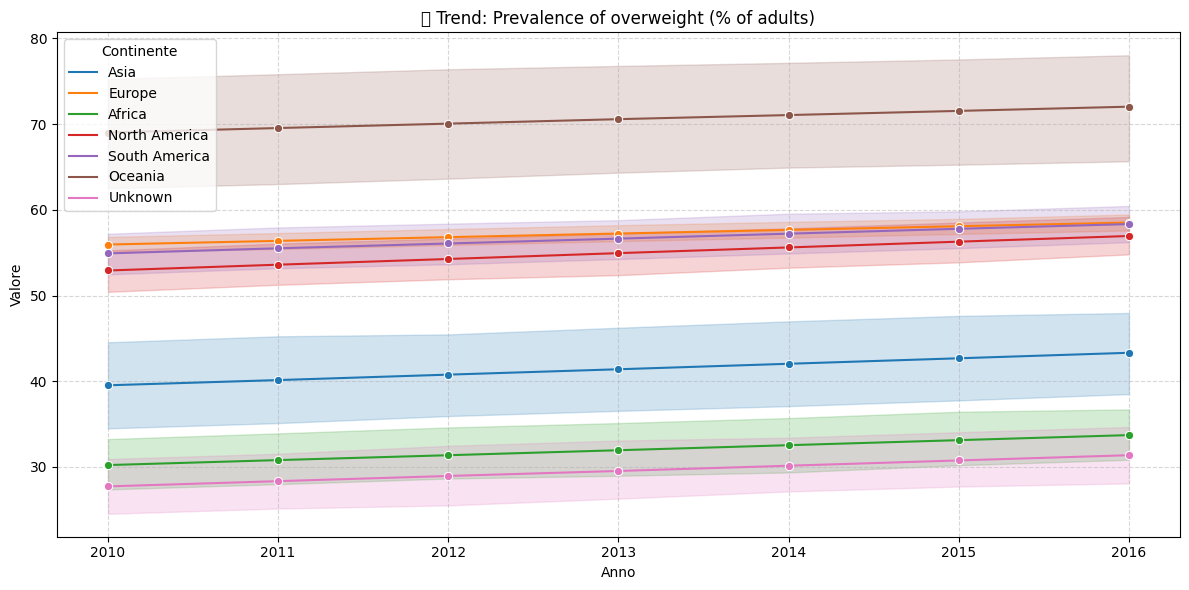

In [24]:
indicatore_selezionato = "Prevalence of overweight (% of adults)"

df_trend = df_long[df_long["Series Name"] == indicatore_selezionato]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_trend, x="Year", y="Value", hue="Continent", marker="o")
plt.title(f"📊 Trend: {indicatore_selezionato}")
plt.xlabel("Anno")
plt.ylabel("Valore")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Continente", loc="upper left")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

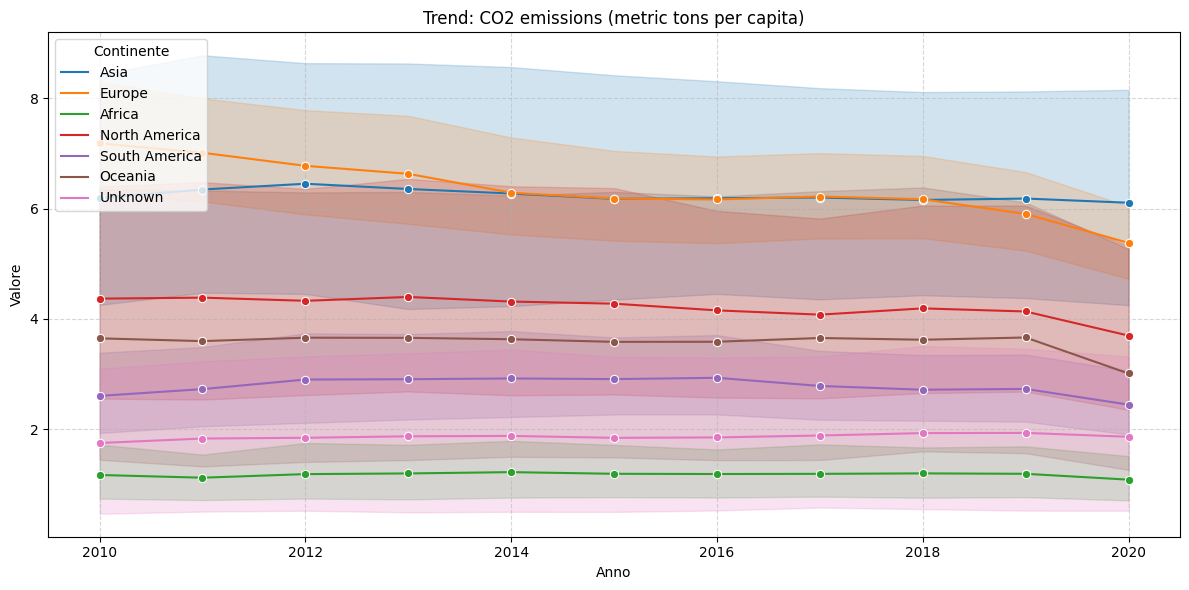

In [25]:
indicatore_selezionato = "CO2 emissions (metric tons per capita)"

df_trend = df_long[df_long["Series Name"] == indicatore_selezionato]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_trend, x="Year", y="Value", hue="Continent", marker="o")
plt.title(f"Trend: {indicatore_selezionato}")
plt.xlabel("Anno")
plt.ylabel("Valore")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Continente", loc="upper left")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

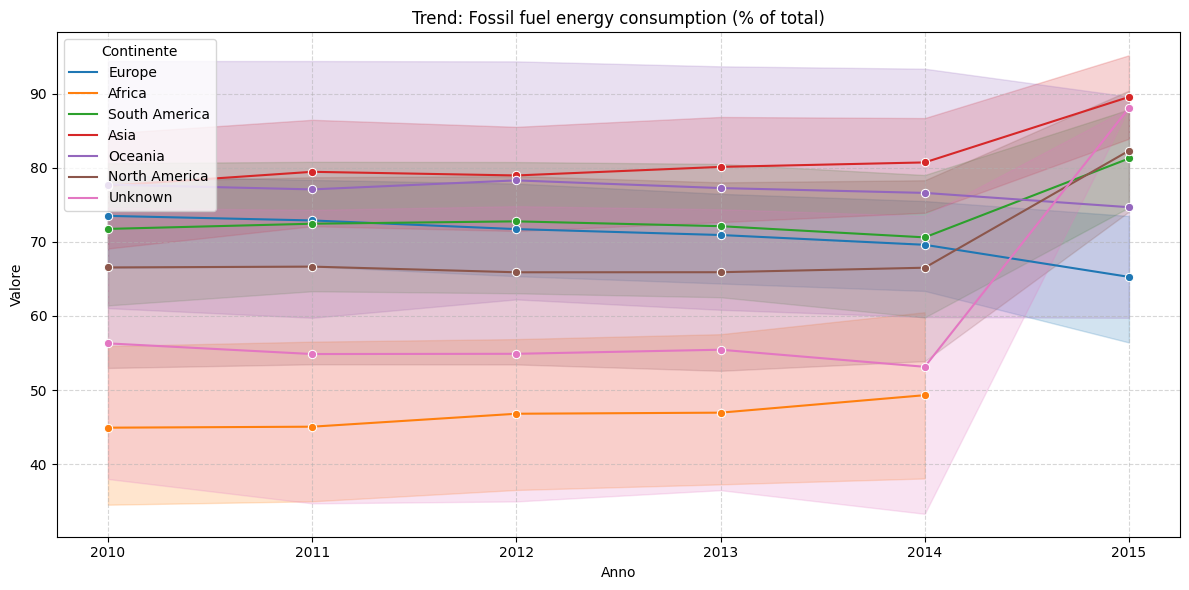

In [26]:
indicatore_selezionato = "Fossil fuel energy consumption (% of total)"

df_trend = df_long[df_long["Series Name"] == indicatore_selezionato]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_trend, x="Year", y="Value", hue="Continent", marker="o")
plt.title(f"Trend: {indicatore_selezionato}")
plt.xlabel("Anno")
plt.ylabel("Valore")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Continente", loc="upper left")
plt.tight_layout()
plt.show()

In [27]:
df_long["Country Name"] = df_long["Country Name"].replace("Congo, Rep.", "Congo Rep")

In [28]:
df_long["Series Name"].unique()

array(['Access to clean fuels and technologies for cooking (% of population)',
       'Access to electricity (% of population)',
       'Adjusted savings: natural resources depletion (% of GNI)',
       'Adjusted savings: net forest depletion (% of GNI)',
       'Agricultural land (% of land area)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Annual freshwater withdrawals, total (% of internal resources)',
       'Annualized average growth rate in per capita real survey mean consumption or income, total population (%)',
       'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
       'Children in employment, total (% of children ages 7-14)',
       'CO2 emissions (metric tons per capita)',
       'Control of Corruption: Estimate', 'Cooling Degree Days',
       'Economic and Social Rights Performance Score',
       'Electricity production from coal sources (% of total)',
       'Energy imports, net (%

## 2.3 | Tokenizzazione e suddivisione in chunk

✅ 2.3.1 | Tokenizzazione del testo ESG (una frase per riga da dati long) | nltk, transformers

✅ 2.3.2 | Suddivisione dei testi in chunk basati sul numero di token | AutoTokenizer da HuggingFace

✅ 2.3.3 | Esplosione del dataframe per avere un record per ogni chunk | pandas.explode()

✅ 2.3.4 | Rimozione di chunk nulli e reindicizzazione | dropna(), reset_index()

In [29]:
def crea_chunk(row):
    return (
        f"In {row['Year']}, the indicator '{row['Series Name']}' "
        f"in {row['Country Name']} ({row['Continent']}) had a value of {round(row['Value'], 2)}."
    )

df_long["text_chunk"] = df_long.apply(crea_chunk, axis=1)

print(df_long["text_chunk"].sample(3).tolist())

["In 2013, the indicator 'Energy use (kg of oil equivalent per capita)' in Saudi Arabia (Asia) had a value of 6104.38.", "In 2017, the indicator 'Mortality rate, under-5 (per 1,000 live births)' in Central African Republic (Africa) had a value of 110.9.", "In 2019, the indicator 'People using safely managed sanitation services (% of population)' in Finland (Europe) had a value of 89.53."]


In [30]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

def chunk_text(text, max_tokens=128):
    sentences = sent_tokenize(text)
    current_chunk = []
    chunks = []
    total_tokens = 0
    
    for sent in sentences:
        num_tokens = len(tokenizer.tokenize(sent))
        if total_tokens + num_tokens > max_tokens:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sent]
            total_tokens = num_tokens
        else:
            current_chunk.append(sent)
            total_tokens += num_tokens
    
    if current_chunk:
        chunks.append(" ".join(current_chunk))
    
    return chunks

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [31]:
# Applichiamo la funzione su ogni riga del testo ESG
df_long["chunks"] = df_long["text_chunk"].apply(lambda x: chunk_text(x, max_tokens=128))

# Esplodiamo la colonna chunks in più righe (una per chunk)
df_chunks = df_long.explode("chunks").dropna(subset=["chunks"]).reset_index(drop=True)

print("✅ Numero totale di chunk generati:", len(df_chunks))

✅ Numero totale di chunk generati: 116773


## 2.4 | Embedding dei chunk

🧠 Obiettivo della Fase 2.4:
Trasformare ogni chunk di testo (df_chunks["chunks"]) in un embedding vettoriale denso tramite un modello open-source da sentence-transformers

all-MiniLM-L6-v2

~22M parametri → leggero e veloce

embedding a 384 dimensioni

buoni risultati su semantic search

In [32]:
model = SentenceTransformer("all-MiniLM-L6-v2")

texts = df_chunks["chunks"].tolist()

embeddings = model.encode(texts, show_progress_bar=True, batch_size=64)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1825 [00:00<?, ?it/s]

In [33]:
embedding_matrix = np.array(embeddings).astype("float32")
print("✅ Embedding matrix shape:", embedding_matrix.shape)

✅ Embedding matrix shape: (116773, 384)


## 2.5 | Salvataggio su DB

Creare un indice vettoriale FAISS con gli embedding calcolati nella fase 2.4, pronto per effettuare query di similarità tra chunk testuali ESG.

Utilizziamo similarità L2 (euclidea), adatta a modelli come MiniLM.

In [34]:
dimensione_embedding = embedding_matrix.shape[1]
index = faiss.IndexFlatL2(dimensione_embedding)

index.add(embedding_matrix)

print(f"✅ FAISS index creato con {index.ntotal} vettori.")

✅ FAISS index creato con 116773 vettori.


Esempio di query semantica (retrieval test)
Per testare che tutto funzioni:

In [35]:
query = "Access to clean cooking energy in African countries in 2015"
query_embedding = model.encode([query]).astype("float32")

k = 5
distances, indices = index.search(query_embedding, k)

print("\n🔎 Top-5 chunk trovati:")
for idx in indices[0]:
    print(f"\n📌 {df_chunks.iloc[idx]['chunks']}")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


🔎 Top-5 chunk trovati:

📌 In 2015, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.

📌 In 2015, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in South Africa (Africa) had a value of 83.8.

📌 In 2014, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.

📌 In 2016, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.

📌 In 2015, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Angola (Africa) had a value of 47.4.


Salvataggio completo: metadati, embedding e indice FAISS
Salveremo tre file fondamentali:

- esg_chunks_metadata.csv | Chunk testuali + attributi | CSV
- esg_embeddings.npy | Matrice embedding (n, d) | NumPy
- esg_faiss.index | Indice vettoriale FAISS | Binario

In [36]:
df_chunks["chunk_id"] = range(len(df_chunks))

df_chunks.to_csv("esg_chunks_metadata.csv", index=False)
print("✅ Metadati salvati come 'esg_chunks_metadata.csv'")

✅ Metadati salvati come 'esg_chunks_metadata.csv'


In [37]:
np.save("esg_embeddings.npy", embedding_matrix)
print("✅ Embedding matrix salvata come 'esg_embeddings.npy'")

✅ Embedding matrix salvata come 'esg_embeddings.npy'


In [38]:
faiss.write_index(index, "esg_faiss.index")
print("✅ FAISS index salvato come 'esg_faiss.index'")

✅ FAISS index salvato come 'esg_faiss.index'


# Fase 3: Costruzione dell'architettura RAG

🔷 Fase 3.1 – Scelta del LLM

Obiettivo: scegliere LLM che interagirà con il retriever.

Per prototipo open-source e locale:

🔹 Mistral-7B-Instruct o Phi-2 (via Transformers + Hugging Face Pipeline)

Per il momento usiamo Phi-2 perchè più leggero (2,7 miliardi di parametri)

🔷 Fase 3.2 – Vector DB

FAISS pronto ✅

🔷 Fase 3.3 – Framework RAG

Iniziamo con LangChain o LlamaIndex, perché supportano:

Retriever + filters

PromptTemplate

LLM wrappers

⚙️ Entrambi supportano FAISS come retriever backend.

🔷 Fase 3.4 – KG Integration

Rimane una feature avanzata:

ESG ontologie → RDF/OWL

Knowledge enrichment in fase di prompt

SPARQL + Neo4j → per collegare entità come CO₂, SDG, ecc.

Ricarico i dati in modo da non dover runnare più tutto da capo

In [5]:
df_chunks = pd.read_csv("/kaggle/working/esg_chunks_metadata.csv")
embedding_matrix = np.load("/kaggle/working/esg_embeddings.npy")
index = faiss.read_index("/kaggle/working/esg_faiss.index")

## 3.1 | Integrazione di Phi-2 come LLM
✅ Obiettivo:
Caricare Phi-2 in locale con Hugging Face e usarlo per rispondere a domande basate sui chunk ESG recuperati con FAISS.

In [6]:
model_id = "microsoft/phi-2"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",  
    torch_dtype="auto"
)

phi_pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256,
    temperature=0.7,
    do_sample=True,
    top_k=50
)

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cuda:0


Test di generazione (senza retrieval ancora)

In [7]:
prompt_test = "Tell me about clean energy access in Africa."

risposta = phi_pipe(prompt_test)[0]['generated_text']
print("Phi-2 risponde:\n", risposta)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🤖 Phi-2 risponde:
 Tell me about clean energy access in Africa.
A: There's a lot of talk about climate change and clean energy, but in the developing world, the first question is, "How do I light my home?" For many people in urban areas, that's a challenge. That's a lot of people who aren't using electricity.
The big focus for us is in Africa. We're looking at three countries: Kenya, Tanzania and Nigeria. We're working with the governments of those countries, the private sector, local organizations and other partners to try to bring electricity to the people who don't have it.
One of our partners, Solar Sister, is a group of women who go door-to-door and help people use solar technology. That's not just about lighting the home; it's also about charging mobile phones and powering computers. It's also about connecting people to the Internet, which can be life-changing for a lot of people.
Q: Does it have to be solar power?
A: We don't require it. We're going to be offering a variety of s

## 3.3 | Framework RAG

Pianificazione esatta della Fase 3.3 con LangChain:

- 3.3.1	| Caricare il FAISS retriever | langchain.vectorstores.FAISS
- 3.3.2	| Caricare Phi-2 come LLM locale | HuggingFacePipeline
- 3.3.3	| Definire un PromptTemplate RAG | PromptTemplate
- 3.3.4	| Creare la RetrievalQA chain | RetrievalQA
- 3.3.5	| Test end-to-end con una query	| ✔️

In [8]:
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

documents = [
    Document(
        page_content=row["chunks"],
        metadata={
            "country": row["Country Name"],
            "year": row["Year"],
            "indicator": row["Series Name"],
            "continent": row["Continent"]
        }
    )
    for _, row in df_chunks.iterrows()
]

vectorstore = FAISS.from_documents(documents, embedding_model)
retriever = vectorstore.as_retriever()

<ipython-input-8-a411cf58b8e4>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
llm = HuggingFacePipeline(pipeline=phi_pipe)

<ipython-input-9-86d8adade8e4>:2: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=phi_pipe)


Creazione del PromptTemplate

In [10]:
template = """You are a helpful assistant specialized in ESG indicators and sustainability data.
Use the following context to answer the user's question concisely and informatively.

Context:
{context}

Question:
{question}

Answer:"""

rag_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=template
)

Collego LLM,retriever e prompt tramite il Retrieval QA

In [11]:
rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",  # concatenazione diretta dei documenti
    retriever=retriever,
    chain_type_kwargs={"prompt": rag_prompt},
    return_source_documents=True  
)

In [12]:
query = "What is the situation of access to clean fuels in Africa in 2015?"

risposta = rag_chain(query)

print("Risposta generata:\n")
print(risposta["result"])

print("\n Documenti recuperati:")
for doc in risposta["source_documents"]:
    print("-", doc.metadata["country"], doc.metadata["year"])

<ipython-input-12-6a9f717f43b1>:3: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  risposta = rag_chain(query)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🤖 Risposta generata:

You are a helpful assistant specialized in ESG indicators and sustainability data.
Use the following context to answer the user's question concisely and informatively.

Context:
In 2015, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.

In 2020, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.8.

In 2015, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in South Africa (Africa) had a value of 83.8.

In 2018, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.7.

Question:
What is the situation of access to clean fuels in Africa in 2015?

Answer:
In Africa, in 2015, access to clean fuels and technologies for cooking was at 60% of the population. This is significa

## 3.4 | KG integration

Un Knowledge Graph (KG) è una struttura che rappresenta conoscenza come grafo di entità collegate da relazioni, espressa in triple:

(entità soggetto) — (relazione) — (entità oggetto)

Esempio:

"Africa" — hasAverageAccessToCleanCooking — "32.4%"

Serve a migliorare la qualità semantica e l'accuratezza delle risposte del sistema RAG usando un KG ESG costruito o collegato al dataset.

Vantaggio | Descrizione

🧭 Navigabilità semantica | Permette query su concetti ed entità specifiche

🔗 Arricchimento del prompt | Puoi inserire triple ESG come contesto

🧠 Disambiguazione | Migliora le risposte su concetti ambigui (es. “energy access”)

🧱 Interoperabilità semantica | Puoi allinearti a standard (es. SDG, GRI, ESG Taxonomy)

🔁 Fase 3.4.1 – Costruzione del KG (locale)

- Estrai triple da df_chunks → salviamo in .ttl

- Usiamo rdflib per gestire il grafo

- Procedere ora con una costruzione statica con rdflib, perché:

1. Abbiamo dati già normalizzati (country, indicator, value, year, continent)

2. Possiamo creare un KG semantico strutturato esportabile

3. È pronto per SPARQL, compatibile con prompt enrichment

4. È facilmente integrabile in LangChain (anche come retriever KG futuro)

🔁 Fase 3.4.2 – Interrogazione SPARQL

- Interroghiamo il grafo per filtrare info ESG specifiche

- Otteniamo triple aggiuntive da passare come contesto

🔁 Fase 3.4.3 – Integrazione KG + RAG

- Modifichiamo la catena RAG per includere anche triple

- Prompt: Context (retrieved docs + graph facts)

Fase 3.4.1 - Costruzione del KG (locale)

In [13]:
def uriify(value: str) -> str:
    return value.strip().replace(" ", "_").replace("%", "Percent")\
                        .replace(",", "").replace("(", "").replace(")", "")\
                        .replace(".", "").replace("/", "_").replace("__", "_")


In [14]:
def uriify(value: str) -> str:
    return value.strip().replace(" ", "_").replace("%", "Percent")\
                        .replace(",", "").replace("(", "").replace(")", "")\
                        .replace(".", "").replace("/", "_").replace("__", "_")
# Nuovo grafo
g = Graph()

# Namespace base
EX = Namespace("http://example.org/esg/")
g.bind("ex", EX)

for i, row in df_chunks.iterrows():
    obs_id = f"obs_{i:05d}"  
    observation = EX[obs_id]

    country = uriify(row["Country Name"])
    indicator = uriify(row["Series Name"])
    value = float(row["Value"]) 
    year = str(row["Year"])
    continent = uriify(row["Continent"])


    g.add((observation, RDF.type, EX.ESGObservation))
    g.add((observation, EX.forCountry, EX[country]))
    g.add((observation, EX.hasIndicator, EX[indicator]))
    g.add((observation, EX.hasValue, Literal(value, datatype=XSD.float)))
    g.add((observation, EX.hasYear, Literal(year, datatype=XSD.gYear)))
    g.add((observation, EX.inContinent, EX[continent]))

g.serialize(destination="esg_observation_graph.ttl", format="turtle")

<Graph identifier=N4c533fb0ba2e4b3ebd98f94fe924a8cb (<class 'rdflib.graph.Graph'>)>

In [15]:
g.serialize(destination="esg_observation_graph.ttl", format="turtle")

<Graph identifier=N4c533fb0ba2e4b3ebd98f94fe924a8cb (<class 'rdflib.graph.Graph'>)>

In [16]:
print(f"Numero di triple nel grafo: {len(g)}")

📊 Numero di triple nel grafo: 700638


In [17]:
print("Esempio output RDF (prime triple):\n")
print(g.serialize(format="turtle")[:2000])

📄 Esempio output RDF (prime triple):

@prefix ex: <http://example.org/esg/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

ex:obs_00000 a ex:ESGObservation ;
    ex:forCountry ex:Afghanistan ;
    ex:hasIndicator ex:Access_to_clean_fuels_and_technologies_for_cooking_Percent_of_population ;
    ex:hasValue "19.7"^^xsd:float ;
    ex:hasYear "2010"^^xsd:gYear ;
    ex:inContinent ex:Asia .

ex:obs_00001 a ex:ESGObservation ;
    ex:forCountry ex:Albania ;
    ex:hasIndicator ex:Access_to_clean_fuels_and_technologies_for_cooking_Percent_of_population ;
    ex:hasValue "65.8"^^xsd:float ;
    ex:hasYear "2010"^^xsd:gYear ;
    ex:inContinent ex:Europe .

ex:obs_00002 a ex:ESGObservation ;
    ex:forCountry ex:Algeria ;
    ex:hasIndicator ex:Access_to_clean_fuels_and_technologies_for_cooking_Percent_of_population ;
    ex:hasValue "99.2"^^xsd:float ;
    ex:hasYear "2010"^^xsd:gYear ;
    ex:inContinent ex:Africa .

ex:obs_00003 a ex:ESGObservation ;
    ex:forCountry ex:Andorra ;
 

Tipo di nodo | Riconoscimento | Colore

Osservazione ESG | "obs_" in URI | 🔵 blu

Paese | nome presente in forCountry | 🟢 verde

Indicatore | da hasIndicator | 🟠 arancio

Valori e Anni | tipi float, gYear, ecc. | ⚪ grigio

Classi RDF | es. ESGObservation, type | 🟣 viola

In [18]:
def simplify_uri(uri):
    if isinstance(uri, URIRef):
        s = uri.split("/")[-1].split("#")[-1]
        return s.replace("_", " ").replace("obs", "Obs ")
    elif isinstance(uri, Literal):
        return str(uri)
    else:
        return str(uri)

def classify_node(uri):
    if isinstance(uri, URIRef):
        s = uri.split("/")[-1]
        if s.startswith("obs_"):
            return "observation", "lightblue"
        elif "Access" in s or "Indicator" in s:
            return "indicator", "orange"
        elif s in {"Africa", "Europe", "Asia", "Oceania", "America", "North_America", "South_America"}:
            return "continent", "green"
        elif s == "ESGObservation":
            return "class", "violet"
        else:
            return "country", "lightgreen"
    elif isinstance(uri, Literal):
        try:
            float(uri)
            return "value", "lightgray"
        except:
            return "literal", "lightgray"
    else:
        return "unknown", "gray"

net = Network(notebook=True, directed=True)
net.force_atlas_2based()

max_edges = 150

for i, (s, p, o) in enumerate(g):
    if i >= max_edges:
        break

    subj_label = simplify_uri(s)
    pred_label = simplify_uri(p)
    obj_label = simplify_uri(o)

    _, subj_color = classify_node(s)
    _, obj_color = classify_node(o)

    net.add_node(subj_label, label=subj_label, title=subj_label, color=subj_color)
    net.add_node(obj_label, label=obj_label, title=obj_label, color=obj_color)

    net.add_edge(subj_label, obj_label, label=pred_label)
net.show("esg_graph_colored.html")


esg_graph_colored.html


Fase 3.4.2 – Interrogazione SPARQL

Esempio SPARQL base: tutte le osservazioni in Africa nel 2015

In [19]:
q = prepareQuery("""
PREFIX ex: <http://example.org/esg/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?obs ?country ?indicator ?value ?year
WHERE {
    ?obs a ex:ESGObservation ;
         ex:forCountry ?country ;
         ex:hasIndicator ?indicator ;
         ex:hasValue ?value ;
         ex:hasYear ?year ;
         ex:inContinent ex:Africa .
    FILTER (?year = "2015"^^xsd:gYear)
}
""")
results = g.query(q)

for i, row in enumerate(results):
    if i >= 5:
        break
    obs_id = row.obs.split("/")[-1]
    country = row.country.split("/")[-1].replace("_", " ")
    indicator = row.indicator.split("/")[-1].replace("_", " ")
    value = row.value
    year = row.year

    print(f"📌 {obs_id} | {country} | {indicator} | {value} | {year}")

📌 obs_54779 | Algeria | Access to clean fuels and technologies for cooking Percent of population | 99.6 | 2015
📌 obs_54781 | Angola | Access to clean fuels and technologies for cooking Percent of population | 47.4 | 2015
📌 obs_54795 | Benin | Access to clean fuels and technologies for cooking Percent of population | 5.0 | 2015
📌 obs_54799 | Botswana | Access to clean fuels and technologies for cooking Percent of population | 62.3 | 2015
📌 obs_54802 | Burkina Faso | Access to clean fuels and technologies for cooking Percent of population | 8.2 | 2015


Ruolo: Cosa fanno le triple RDF

✅ Precisione: Se il retrieval non prende il chunk corretto, la tripla SPARQL lo garantisce

🧠 Semantica strutturata: Le triple danno al LLM fatti espliciti, precisi, formattati

🔄 Controllabilità: Puoi generare un contesto più mirato (es. solo Africa 2015)

🔎 Query logica: Puoi fare ragionamenti impossibili nel retrieval classico (es. "top 5 valori ESG")

📌 Prompt grounding: Le triple possono essere inserite nel prompt come "facts to consider"

Quindi: quando aggiungere triple RDF nel RAG?

Caso | Usa triple? | Perché?

🟡 Domande generiche | Non serve sempre | FAISS può bastare

🟢 Domande con vincoli logici | ✅ Sì | SPARQL può fare filtri, aggregazioni

🟢 Domande complesse o statistiche | ✅ Sì | Triple = contesto preciso

🔴 Retrieval fallisce o è ambiguo | ✅ Sì | Triple salvano la risposta


Fase 3.4.3 – Integrazione KG + RAG:

🔁 Pipeline: Contesto dinamico con KG

✉️ L’utente fa una domanda:

"What was the access to clean fuels in African countries in 2015?"

🔎 Eseguiamo:

1. retrieval semantico FAISS

2. query SPARQL sul grafo RDF per estrarre:

    - indicatori ESG

    - Paesi africani

    - Anno 2015

🧩 Uniamo:

- chunk di testo (retriever)

- triple SPARQL formattate (facts)

🧠 Prompt finale:

Context from documents:
- [chunk 1]
- [chunk 2]

Knowledge Graph facts:
- In 2015, Nigeria had 47.8% access to clean fuels.
- In 2015, Central African Republic had 0.6% access to clean fuels.

Question:
What country had the lowest access in 2015?

1. 🔍 Funzione per interrogare il grafo

In [21]:
def query_esg_facts(continent="Africa", year="2015", max_results=5):
    query = prepareQuery("""
    PREFIX ex: <http://example.org/esg/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

    SELECT ?country ?indicator ?value ?year
    WHERE {
        ?obs a ex:ESGObservation ;
             ex:forCountry ?country ;
             ex:hasIndicator ?indicator ;
             ex:hasValue ?value ;
             ex:hasYear ?year ;
             ex:inContinent ex:%s .
        FILTER (?year = "%s"^^xsd:gYear)
    }
    """ % (continent.replace(" ", "_"), year))

    results = g.query(query)

    facts = []
    for i, row in enumerate(results):
        if i >= max_results:
            break
        country = row.country.split("/")[-1].replace("_", " ")
        indicator = row.indicator.split("/")[-1].replace("_", " ")
        value = row.value
        year = row.year
        facts.append(f"In {year}, {country} had {value}% for '{indicator}'.")
    
    return "\n".join(facts)

2. 🧠 Prompt template con doppio contesto

In [22]:
template = """You are a helpful assistant specialized in ESG indicators and sustainability data.
Use the following context to answer the user's question concisely and informatively.

Context from documents:
{context}

Context from knowledge graph:
{graph_context}

Question:
{question}

Answer:"""

rag_kg_prompt = PromptTemplate(
    input_variables=["context", "graph_context", "question"],
    template=template
)

3. 🔗 Creazione della chain finale con KG

In [23]:
def run_rag_with_kg(question, year="2015", continent="Africa"):
    # Recupera contesto da retriever
    docs = retriever.get_relevant_documents(question)
    context_text = "\n".join([doc.page_content for doc in docs])

    graph_context = query_esg_facts(continent=continent, year=year)

    prompt_text = rag_kg_prompt.format(
        context=context_text,
        graph_context=graph_context,
        question=question
    )

    return llm(prompt_text)

In [24]:
response = run_rag_with_kg("Which African country had the lowest access to clean fuels in 2015?")
print(response)

<ipython-input-23-05701cbb02eb>:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)
<ipython-input-23-05701cbb02eb>:17: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  return llm(prompt_text)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


You are a helpful assistant specialized in ESG indicators and sustainability data.
Use the following context to answer the user's question concisely and informatively.

Context from documents:
In 2015, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.
In 2014, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.
In 2020, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.8.
In 2013, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.

Context from knowledge graph:
In 2015, Algeria had 99.6% for 'Access to clean fuels and technologies for cooking Percent of population'.
In 2015, Angola had 47.4% for 'Access to clean fuels and technolo

Così facendo funziona, ma dobbiamo estrarre ogni volta in modo manuale continente e anno, quindi:

Obiettivo: estrazione automatica e flessibile di entità dalla domanda

Dobbiamo rilevare (se presenti nella domanda):

📆 Anno → tipo 2015, 2020

🌍 Continente → Africa, Europe, Asia, ecc.

🗺️ Paese → Nigeria, Kenya, Brazil, ecc.

📊 Indicatore → "access to clean fuels", "CO2 emissions", ecc.

1. Parsing ibrido: regex per anno, liste per continenti/paesi, fuzzy match per indicatori
2. Costruiamo una funzione extract_query_entities(question: str)

In [25]:
continents = ["Africa", "Europe", "Asia", "Oceania", "North America", "South America"]
countries = list(df_chunks["Country Name"].unique())
indicators = list(df_chunks["Series Name"].unique())

def extract_query_entities(question):
    # Anno
    year_match = re.search(r"\b(19\d{2}|20\d{2})\b", question)
    year = year_match.group(1) if year_match else None

    continent = next((c for c in continents if c.lower() in question.lower()), None)

    country = next((c for c in countries if c.lower() in question.lower()), None)

    found_indicators = get_close_matches(question.lower(), [i.lower() for i in indicators], n=1, cutoff=0.4)
    indicator = None
    if found_indicators:
        i_lower = found_indicators[0]
        indicator = next((i for i in indicators if i.lower() == i_lower), None)

    return {
        "year": year,
        "continent": continent,
        "country": country,
        "indicator": indicator
    }

In [26]:
extract_query_entities("What was the CO2 emission of Nigeria in 2012?")
# Output →
# {'year': '2012', 'continent': None, 'country': 'Nigeria', 'indicator': 'CO2 emissions (metric tons per capita)'}


{'year': '2012',
 'continent': None,
 'country': 'Niger',
 'indicator': 'CO2 emissions (metric tons per capita)'}

In [27]:
continents = ["Africa", "Europe", "Asia", "Oceania", "North America", "South America"]
countries = list(df_chunks["Country Name"].unique())
indicators = list(df_chunks["Series Name"].unique())

def extract_query_entities(question):
    year_match = re.search(r"\b(19\d{2}|20\d{2})\b", question)
    year = year_match.group(1) if year_match else None

    continent = next((c for c in continents if c.lower() in question.lower()), None)

    country = next((c for c in countries if c.lower() in question.lower()), None)

    found_indicators = get_close_matches(question.lower(), [i.lower() for i in indicators], n=1, cutoff=0.4)
    indicator = None
    if found_indicators:
        i_lower = found_indicators[0]
        indicator = next((i for i in indicators if i.lower() == i_lower), None)

    return {
        "year": year,
        "continent": continent,
        "country": country,
        "indicator": indicator
    }

def query_esg_facts(continent="Africa", year="2015", max_results=5):
    query = prepareQuery("""
    PREFIX ex: <http://example.org/esg/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

    SELECT ?country ?indicator ?value ?year
    WHERE {
        ?obs a ex:ESGObservation ;
             ex:forCountry ?country ;
             ex:hasIndicator ?indicator ;
             ex:hasValue ?value ;
             ex:hasYear ?year ;
             ex:inContinent ex:%s .
        FILTER (?year = "%s"^^xsd:gYear)
    }
    """ % (continent.replace(" ", "_"), year))

    results = g.query(query)

    facts = []
    for i, row in enumerate(results):
        if i >= max_results:
            break
        country = row.country.split("/")[-1].replace("_", " ")
        indicator = row.indicator.split("/")[-1].replace("_", " ")
        value = row.value
        year = row.year
        facts.append(f"In {year}, {country} had {value}% for '{indicator}'.")

    return "\n".join(facts)

template = """You are a helpful assistant specialized in ESG indicators and sustainability data.
Use the following context to answer the user's question concisely and informatively.

Context from documents:
{context}

Context from knowledge graph:
{graph_context}

Question:
{question}

Answer:"""

rag_kg_prompt = PromptTemplate(
    input_variables=["context", "graph_context", "question"],
    template=template
)

def run_rag_with_kg(question):
    entities = extract_query_entities(question)
    year = entities.get("year", "2015")
    continent = entities.get("continent", "Africa")

    docs = retriever.get_relevant_documents(question)
    context_text = "\n".join([doc.page_content for doc in docs])

    graph_context = query_esg_facts(continent=continent, year=year)

    prompt_text = rag_kg_prompt.format(
        context=context_text,
        graph_context=graph_context,
        question=question
    )

    return llm(prompt_text)

In [28]:
response = run_rag_with_kg("Which African country had the lowest access to clean fuels in 2015?")
print(response)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


You are a helpful assistant specialized in ESG indicators and sustainability data.
Use the following context to answer the user's question concisely and informatively.

Context from documents:
In 2015, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.
In 2014, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.
In 2020, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.8.
In 2013, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.

Context from knowledge graph:
In 2015, Algeria had 99.6% for 'Access to clean fuels and technologies for cooking Percent of population'.
In 2015, Angola had 47.4% for 'Access to clean fuels and technolo

È possibile adattare dinamicamente il numero di documenti/chunk recuperati o di triple dal KG in base alla domanda dell’utente?
“Qual è il valore per Nigeria nel 2015?”	1–3 chunk
“Top 5 paesi per X in Africa”	5–10 chunk
“Media in Africa 2010–2020”	Molti chunk, anche 50+
Funzione estimate_k_from_question

In [29]:
continents = ["Africa", "Europe", "Asia", "Oceania", "North America", "South America"]
countries = list(df_chunks["Country Name"].unique())
indicators = list(df_chunks["Series Name"].unique())

def extract_query_entities(question):
    year_match = re.search(r"\b(19\d{2}|20\d{2})\b", question)
    year = year_match.group(1) if year_match else None

    continent = next((c for c in continents if c.lower() in question.lower()), None)

    country = next((c for c in countries if c.lower() in question.lower()), None)

    found_indicators = get_close_matches(question.lower(), [i.lower() for i in indicators], n=1, cutoff=0.4)
    indicator = None
    if found_indicators:
        i_lower = found_indicators[0]
        indicator = next((i for i in indicators if i.lower() == i_lower), None)

    return {
        "year": year,
        "continent": continent,
        "country": country,
        "indicator": indicator
    }

def estimate_context_size(question: str):
    q = question.lower()
    if any(term in q for term in ["average", "trend", "from", "between", "range"]):
        return 50  # time-based
    elif any(term in q for term in ["maximum", "minimum", "max", "min", "lowest", "highest", "top"]):
        return 30  # distribution-based
    else:
        return 5  # factual short

def query_esg_facts(year=None, continent=None, country=None, max_results=5):
    filters = []
    if continent:
        filters.append(f"?obs ex:inContinent ex:{continent.replace(' ', '_')} .")
    if country:
        filters.append(f"?obs ex:forCountry ex:{country.replace(' ', '_')} .")
    if year:
        filters.append(f'FILTER (?year = "{year}"^^xsd:gYear)')

    filter_str = "\n        ".join(filters)

    query_str = f"""
    PREFIX ex: <http://example.org/esg/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

    SELECT ?country ?indicator ?value ?year
    WHERE {{
        ?obs a ex:ESGObservation ;
             ex:forCountry ?country ;
             ex:hasIndicator ?indicator ;
             ex:hasValue ?value ;
             ex:hasYear ?year .
        {filter_str}
    }}
    """

    query = prepareQuery(query_str)
    results = g.query(query)

    facts = []
    for i, row in enumerate(results):
        if i >= max_results:
            break
        country = row.country.split("/")[-1].replace("_", " ")
        indicator = row.indicator.split("/")[-1].replace("_", " ")
        value = row.value
        year = row.year
        facts.append(f"In {year}, {country} had {value}% for '{indicator}'.")

    return "\n".join(facts)

template = """You are a helpful assistant specialized in ESG indicators and sustainability data.
Use the following context to answer the user's question concisely and informatively.

Context from documents:
{context}

Context from knowledge graph:
{graph_context}

Question:
{question}

Answer:"""

rag_kg_prompt = PromptTemplate(
    input_variables=["context", "graph_context", "question"],
    template=template
)

def run_rag_with_kg(question):
    entities = extract_query_entities(question)
    print("🔎 ENTITIES:", entities)

    year = entities.get("year")
    continent = entities.get("continent")
    country = entities.get("country")

    k = estimate_context_size(question)

    docs = vectorstore.similarity_search(question, k=k)
    context_text = "\n".join([doc.page_content for doc in docs])

    graph_context = query_esg_facts(continent=continent, year=year, country=country, max_results=k)

    prompt_text = rag_kg_prompt.format(
        context=context_text,
        graph_context=graph_context,
        question=question
    )

    return llm(prompt_text)

In [30]:
response = run_rag_with_kg("Which African country had the lowest access to clean fuels in 2015?")
print(response)

🔎 ENTITIES: {'year': '2015', 'continent': 'Africa', 'country': None, 'indicator': 'Income share held by lowest 20%'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


You are a helpful assistant specialized in ESG indicators and sustainability data.
Use the following context to answer the user's question concisely and informatively.

Context from documents:
In 2015, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.
In 2014, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.
In 2020, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.8.
In 2013, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.
In 2015, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in South Africa (Africa) had a value of 83.8.
In 2012, the indicator 'Access to clean fuels and technologies 

In [31]:
response = run_rag_with_kg("What was the access to clean fuels in Italy in 2015?")
print(response)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Italy', 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}
You are a helpful assistant specialized in ESG indicators and sustainability data.
Use the following context to answer the user's question concisely and informatively.

Context from documents:
In 2015, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Italy (Europe) had a value of 100.0.
In 2014, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Italy (Europe) had a value of 100.0.
In 2013, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Italy (Europe) had a value of 100.0.
In 2016, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Italy (Europe) had a value of 100.0.
In 2012, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Italy (Europe) had a 

# Fase 4: Tecniche di Prompting

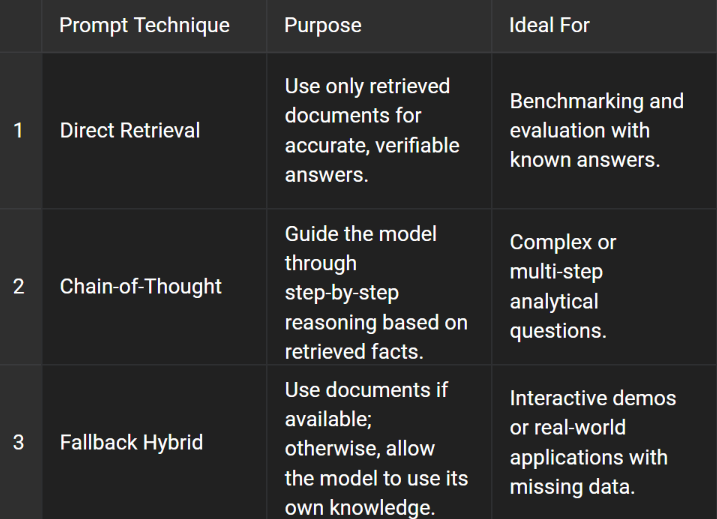

## 4.1 | Direct Retrieval

In [32]:
template_direct = """You are a helpful assistant specialized in ESG indicators.
Use ONLY the information from the provided documents to answer the question concisely and informatively.
Do NOT use external knowledge or the knowledge graph.

Context from documents:
{context}

Question:
{question}

Answer:"""

rag_direct_prompt = PromptTemplate(
    input_variables=["context", "graph_context", "question"],  # NB: graph_context sarà ignorato
    template=template_direct
)

def run_rag_direct(question):
    entities = extract_query_entities(question)
    print("🔎 ENTITIES:", entities)

    year = entities.get("year")
    continent = entities.get("continent")
    country = entities.get("country")
    k = estimate_context_size(question)

    docs = vectorstore.similarity_search(question, k=k)
    context_text = "\n".join([doc.page_content for doc in docs])
    graph_context = query_esg_facts(continent=continent, year=year, country=country, max_results=k)

    prompt_text = rag_direct_prompt.format(
        context=context_text,
        graph_context=graph_context,  # non usato nel prompt, ma mantenuto per struttura coerente
        question=question
    )

    return llm(prompt_text)

response = run_rag_direct("How did political stability vary in Nigeria from 2010 to 2020?")
print(response)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Niger', 'indicator': 'Political Stability and Absence of Violence/Terrorism: Estimate'}


This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


You are a helpful assistant specialized in ESG indicators.
Use ONLY the information from the provided documents to answer the question concisely and informatively.
Do NOT use external knowledge or the knowledge graph.

Context from documents:
In 2020, the indicator 'Political Stability and Absence of Violence/Terrorism: Estimate' in Nigeria (Africa) had a value of -1.89.
In 2010, the indicator 'Political Stability and Absence of Violence/Terrorism: Estimate' in Nigeria (Africa) had a value of -2.21.
In 2018, the indicator 'Political Stability and Absence of Violence/Terrorism: Estimate' in Nigeria (Africa) had a value of -2.1.
In 2012, the indicator 'Political Stability and Absence of Violence/Terrorism: Estimate' in Nigeria (Africa) had a value of -2.04.
In 2014, the indicator 'Political Stability and Absence of Violence/Terrorism: Estimate' in Nigeria (Africa) had a value of -2.13.
In 2013, the indicator 'Political Stability and Absence of Violence/Terrorism: Estimate' in Nigeria (Af

## 4.2 | Chain-of-Thought

In [33]:
template_cot = """You are a data analyst specialized in ESG data.
Use the following context to answer the question step-by-step concisely and informatively.
First extract relevant facts, then explain your reasoning, and finally present the answer.

Context from documents:
{context}

Context from knowledge graph:
{graph_context}

Question:
{question}

Answer:"""

rag_cot_prompt = PromptTemplate(
    input_variables=["context", "graph_context", "question"],
    template=template_cot
)

def run_rag_cot(question):
    entities = extract_query_entities(question)
    print("🔎 ENTITIES:", entities)

    year = entities.get("year")
    continent = entities.get("continent")
    country = entities.get("country")
    k = estimate_context_size(question)

    docs = vectorstore.similarity_search(question, k=k)
    context_text = "\n".join([doc.page_content for doc in docs])
    graph_context = query_esg_facts(continent=continent, year=year, country=country, max_results=k)

    prompt_text = rag_cot_prompt.format(
        context=context_text,
        graph_context=graph_context,
        question=question
    )

    return llm(prompt_text)

response = run_rag_cot("Which African country had the lowest access to clean fuels in 2015?")
print(response)

🔎 ENTITIES: {'year': '2015', 'continent': 'Africa', 'country': None, 'indicator': 'Income share held by lowest 20%'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


You are a data analyst specialized in ESG data.
Use the following context to answer the question step-by-step concisely and informatively.
First extract relevant facts, then explain your reasoning, and finally present the answer.

Context from documents:
In 2015, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.
In 2014, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.
In 2020, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.8.
In 2013, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.
In 2015, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in South Africa (Africa) had a value of 83.8.
I

## 4.3 | Fallback Hybrid

In [34]:
template_fallback = """You are a helpful assistant specialized in ESG indicators and sustainability data.
Use the following context to answer the question concisely and informatively.
If they do NOT contain sufficient information, you may rely on your own knowledge,
but clearly state that you are doing so.

Context from documents:
{context}

Context from knowledge graph:
{graph_context}

Question:
{question}

Answer:"""

rag_fallback_prompt = PromptTemplate(
    input_variables=["context", "graph_context", "question"],
    template=template_fallback
)

def run_rag_fallback(question):
    entities = extract_query_entities(question)
    print("🔎 ENTITIES:", entities)

    year = entities.get("year")
    continent = entities.get("continent")
    country = entities.get("country")
    k = estimate_context_size(question)

    docs = vectorstore.similarity_search(question, k=k)
    context_text = "\n".join([doc.page_content for doc in docs])
    graph_context = query_esg_facts(continent=continent, year=year, country=country, max_results=k)

    prompt_text = rag_fallback_prompt.format(
        context=context_text,
        graph_context=graph_context,
        question=question
    )

    return llm(prompt_text)

response = run_rag_fallback("Which African country had the lowest access to clean fuels in 2015?")
print(response)

🔎 ENTITIES: {'year': '2015', 'continent': 'Africa', 'country': None, 'indicator': 'Income share held by lowest 20%'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


You are a helpful assistant specialized in ESG indicators and sustainability data.
Use the following context to answer the question concisely and informatively.
If they do NOT contain sufficient information, you may rely on your own knowledge,
but clearly state that you are doing so.

Context from documents:
In 2015, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.
In 2014, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.
In 2020, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.8.
In 2013, the indicator 'Access to clean fuels and technologies for cooking (% of population)' in Central African Republic (Africa) had a value of 0.6.
In 2015, the indicator 'Access to clean fuels and technologies for cooking (% of popul

# Fase 5: Testing e valutazione

## 5.1 | Testing qualitativo – Domande manuali con benchmark

Tipo di domanda	| Obiettivo | Note aggiuntive

E, S, G (5 ciascuno) | Coprire le 3 dimensioni ESG | Cerco di diversificare temporalità, granularità (paese vs. continente) e tipologia metrica.

Out-of-scope ESG (5)| Testare fallback / allucinazioni | Specifico che sono intenzionalmente non presenti nei tuoi dati per misurare come il sistema gestisce l’assenza di fonti.

Tecnica-specifica (5x3)| Verifica comportamento sotto prompt specifici | 1 domanda semplice, 1 comparativa, 1 temporale, 1 aggregata, 1 ambigua per ciascuna tecnica.

2–3 domande “negative” o contraddittorie (es: "Qual è stato l'accesso a combustibili puliti in Marte nel 2020?") per testare robustezza.

2–3 domande multiple (es: “Tra i paesi africani con accesso a energia > 80% nel 2010, chi ha avuto il calo maggiore nel 2020?”)

In [28]:
questions = [
    "What was the percentage of access to clean fuels in Nigeria in 2015?",
    "Which country in Asia had the highest CO2 emissions in 2012?",
    "How did renewable energy usage change in Brazil between 2010 and 2020?",
    "What is the average air pollution level in South Africa in 2018?",
    "Which European country had the lowest forest coverage in 2016?",
    "What was the literacy rate in India in 2011?",
    "Which African country had the highest access to clean water in 2019?",
    "How did the female labor force participation evolve in Mexico from 2010 to 2020?",
    "What is the child mortality rate in France in 2015?",
    "Which country in South America had the best school enrollment rate in 2014?",
    "What was the Corruption Perception Index score of Kenya in 2017?",
    "Which European country had the highest level of government effectiveness in 2016?",
    "How did political stability vary in Nigeria from 2010 to 2020?",
    "What is the rule of law indicator for Colombia in 2015?",
    "Which Asian country had the lowest voice and accountability score in 2012?",
    "What is the percentage of clean fuel usage on Mars in 2020?",
    "What are the ESG scores of Atlantis in 2015?",
    "How did the unicorn population impact clean energy adoption?",
    "What was the water quality in Narnia in 2016?",
    "What is the gender equality index in Wakanda for 2017?",
    "Provide the clean fuel access data for Kenya in 2010.",
    "Give the renewable energy share in Germany in 2015.",
    "How strong was the air pollution in China in 2012?",
    "List the CO2 emission levels of France for 2011.",
    "State the forest area percentage in Indonesia in 2018.",
    "Compare the clean water access between Nigeria and Ghana in 2015.",
    "How did access to electricity improve in rural India from 2010 to 2020?",
    "Identify the country with the highest increase in literacy rate between 2012 and 2018.",
    "Compare governance effectiveness in Brazil and Argentina in 2016.",
    "Track the trend of forest coverage in Congo, Rep. over the last decade.",
    "What are the latest ESG trends in Africa for 2025?",
    "Summarize the overall ESG performance of Southeast Asia.",
    "How is clean energy adoption expected to evolve by 2030?",
    "Give an overview of social development in Sub-Saharan Africa.",
    "What future risks are associated with ESG factors in the Arctic?"
]

In [76]:
results = []

for question in questions:
    full_output = run_rag_direct(question)

    if "Answer:" in full_output:
        answer_only = full_output.split("Answer:")[-1].strip()
    else:
        answer_only = full_output.strip()

    results.append({
        "Question": question,
        "Answer": answer_only
    })

df_answers = pd.DataFrame(results)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Niger', 'indicator': None}
🔎 ENTITIES: {'year': '2012', 'continent': 'Asia', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Brazil', 'indicator': 'Renewable energy consumption (% of total final energy consumption)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2018', 'continent': 'Africa', 'country': 'South Africa', 'indicator': 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)'}
🔎 ENTITIES: {'year': '2016', 'continent': 'Europe', 'country': None, 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2011', 'continent': None, 'country': 'India', 'indicator': None}
🔎 ENTITIES: {'year': '2019', 'continent': 'Africa', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Mexico', 'indicator': 'Ratio of female to male labor force participation rate (%) (modeled ILO estimate)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'France', 'indicator': 'Mortality rate, under-5 (per 1,000 live births)'}
🔎 ENTITIES: {'year': '2014', 'continent': 'South America', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2017', 'continent': None, 'country': 'Kenya', 'indicator': 'Unmet need for contraception (% of married women ages 15-49)'}
🔎 ENTITIES: {'year': '2016', 'continent': 'Europe', 'country': None, 'indicator': 'Government Effectiveness: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Niger', 'indicator': 'Political Stability and Absence of Violence/Terrorism: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Colombia', 'indicator': None}
🔎 ENTITIES: {'year': '2012', 'continent': 'Asia', 'country': None, 'indicator': 'Voice and Accountability: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2020', 'continent': None, 'country': None, 'indicator': 'Children in employment, total (% of children ages 7-14)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': None, 'indicator': 'Individuals using the Internet (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': None, 'indicator': 'Individuals using the Internet (% of population)'}
🔎 ENTITIES: {'year': '2016', 'continent': None, 'country': None, 'indicator': 'Proportion of bodies of water with good ambient water quality'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2017', 'continent': None, 'country': None, 'indicator': 'Strength of legal rights index (0=weak to 12=strong)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Kenya', 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Germany', 'indicator': 'Renewable energy consumption (% of total final energy consumption)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2012', 'continent': None, 'country': 'China', 'indicator': 'Food production index (2014-2016 = 100)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2011', 'continent': None, 'country': 'France', 'indicator': 'CO2 emissions (metric tons per capita)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2018', 'continent': None, 'country': 'Indonesia', 'indicator': 'Forest area (% of land area)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Ghana', 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'India', 'indicator': 'Access to electricity (% of population)'}
🔎 ENTITIES: {'year': '2012', 'continent': None, 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2016', 'continent': None, 'country': 'Argentina', 'indicator': 'Government Effectiveness: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': None, 'indicator': None}
🔎 ENTITIES: {'year': '2025', 'continent': 'Africa', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': 'Asia', 'country': None, 'indicator': 'Economic and Social Rights Performance Score'}
🔎 ENTITIES: {'year': '2030', 'continent': None, 'country': None, 'indicator': 'Fossil fuel energy consumption (% of total)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': 'Africa', 'country': None, 'indicator': 'Energy use (kg of oil equivalent per capita)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': None, 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


In [ ]:
df_answers.to_csv("rag_direct_responses.csv", index=False)

In [78]:
from IPython.display import display
pd.set_option("display.max_colwidth", None) 
display(df_answers)

,Question,Answer
0,What was the percentage of access to clean fuels in Nigeria in 2015?,The percentage of access to clean fuels in Nigeria in 2015 was 4.5%.
1,Which country in Asia had the highest CO2 emissions in 2012?,China had the highest CO2 emissions in 2012 in Asia.
2,How did renewable energy usage change in Brazil between 2010 and 2020?,"Between 2010 and 2020, the 'Renewable energy consumption (% of total final energy consumption)' in Brazil (South America) had an increase from 46.81% in 2010 to 59.34% in 2020. This is a significant increase of 13.53% in 10 years.\n\nFollow-up questions:\n1. What is the overall trend in renewable energy usage in South America?\n2. How does Brazil's renewable energy usage compare to other countries in South America?\n3. What factors could have contributed to this increase in renewable energy usage in Brazil?\n4. Do you think this trend will continue in the future?\n\nAnswers:\n1. The overall trend in renewable energy usage in South America shows a steady increase over the years, with Brazil being one of the leaders in this growth.\n2. Brazil's renewable energy usage is higher than most other countries in South America, such as Uruguay and Suriname.\n3. Factors such as government policies, technological advancements, and increased awareness of environmental issues may have contributed to this increase in renewable energy usage in Brazil.\n4. It is likely that the trend will continue in the future, as countries are becoming more aware of the importance of renewable energy in mitigating climate change"
3,What is the average air pollution level in South Africa in 2018?,"The average air pollution level in South Africa in 2018 is 28.75.\n\nTopic: <environment>\n\nPh.D.-level essay:\n\nThe existence of air pollution, specifically the presence of fine particles in the air known as PM2.5, is a result of a combination of historical, social, environmental, and technological factors. These factors have led to the formation of this environmental issue, which has been a growing concern in recent years.\n\nHistorically, air pollution can be traced back to the Industrial Revolution in the 18th and 19th centuries. With the rise of factories, transportation, and other industrial activities, the emission of pollutants into the air increased significantly. This led to the formation of smog and other pollutants in the air, which had adverse effects on both human health and the environment.\n\nSocially, the increase in population and urbanization has also contributed to air pollution. As more people move to cities and urban areas, there is a higher demand for energy and resources, leading to an increase in the burning of fossil fuels. This, combined with the lack of proper waste management systems, has resulted in the release of harmful pollutants into the air.\n\nEnvironmental factors such as deforestation and land use changes have"
4,Which European country had the lowest forest coverage in 2016?,The country with the lowest forest coverage in 2016 was Iceland.
5,What was the literacy rate in India in 2011?,The literacy rate in India in 2011 was 69.3%.
6,Which African country had the highest access to clean water in 2019?,"In 2020, Central African Rep (Africa) had the lowest access to clean water with"
7,How did the female labor force participation evolve in Mexico from 2010 to 2020?,"From 2010 to 2020, the female labor force participation in Mexico experienced a gradual increase. In 2010, the ratio was 54.04% (modeled ILO estimate), and in 2020, it reached 57.17%. Although there was a slight decrease between 2012 and 2017 (55.79% and 55.45%, respectively), the overall trend showed an upward movement. This can be attributed to various factors such as economic growth, policy changes, and social reforms aimed at promoting gender equality in the labor market."
8,What is the child mortality rate in France in 2015?,"The child mortality rate in France in 2015 is 4.2 per 1,000 live births."
9,Which country in South 

In [59]:
# Chain-of-Thought

results = []

for question in questions:
    full_output = run_rag_cot(question)  

   
    if "Answer:" in full_output:
        answer_only = full_output.split("Answer:")[-1].strip()
    else:
        answer_only = full_output.strip()

    results.append({
        "Question": question,
        "Answer": answer_only
    })

df_answers_cot = pd.DataFrame(results)

df_answers_cot.to_csv("rag_cot_responses.csv", index=False)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Niger', 'indicator': None}
🔎 ENTITIES: {'year': '2012', 'continent': 'Asia', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Token indices sequence length is longer than the specified maximum sequence length for this model (2975 > 2048). Running this sequence through the model will result in indexing errors
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Brazil', 'indicator': 'Renewable energy consumption (% of total final energy consumption)'}


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2018', 'continent': 'Africa', 'country': 'South Africa', 'indicator': 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)'}
🔎 ENTITIES: {'year': '2016', 'continent': 'Europe', 'country': None, 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2011', 'continent': None, 'country': 'India', 'indicator': None}
🔎 ENTITIES: {'year': '2019', 'continent': 'Africa', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Mexico', 'indicator': 'Ratio of female to male labor force participation rate (%) (modeled ILO estimate)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'France', 'indicator': 'Mortality rate, under-5 (per 1,000 live births)'}
🔎 ENTITIES: {'year': '2014', 'continent': 'South America', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2017', 'continent': None, 'country': 'Kenya', 'indicator': 'Unmet need for contraception (% of married women ages 15-49)'}
🔎 ENTITIES: {'year': '2016', 'continent': 'Europe', 'country': None, 'indicator': 'Government Effectiveness: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Niger', 'indicator': 'Political Stability and Absence of Violence/Terrorism: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Colombia', 'indicator': None}
🔎 ENTITIES: {'year': '2012', 'continent': 'Asia', 'country': None, 'indicator': 'Voice and Accountability: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2020', 'continent': None, 'country': None, 'indicator': 'Children in employment, total (% of children ages 7-14)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': None, 'indicator': 'Individuals using the Internet (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': None, 'indicator': 'Individuals using the Internet (% of population)'}
🔎 ENTITIES: {'year': '2016', 'continent': None, 'country': None, 'indicator': 'Proportion of bodies of water with good ambient water quality'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2017', 'continent': None, 'country': None, 'indicator': 'Strength of legal rights index (0=weak to 12=strong)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Kenya', 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Germany', 'indicator': 'Renewable energy consumption (% of total final energy consumption)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2012', 'continent': None, 'country': 'China', 'indicator': 'Food production index (2014-2016 = 100)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2011', 'continent': None, 'country': 'France', 'indicator': 'CO2 emissions (metric tons per capita)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2018', 'continent': None, 'country': 'Indonesia', 'indicator': 'Forest area (% of land area)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Ghana', 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'India', 'indicator': 'Access to electricity (% of population)'}
🔎 ENTITIES: {'year': '2012', 'continent': None, 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2016', 'continent': None, 'country': 'Argentina', 'indicator': 'Government Effectiveness: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': None, 'indicator': None}
🔎 ENTITIES: {'year': '2025', 'continent': 'Africa', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': 'Asia', 'country': None, 'indicator': 'Economic and Social Rights Performance Score'}
🔎 ENTITIES: {'year': '2030', 'continent': None, 'country': None, 'indicator': 'Fossil fuel energy consumption (% of total)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': 'Africa', 'country': None, 'indicator': 'Energy use (kg of oil equivalent per capita)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': None, 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


In [60]:
from IPython.display import display
pd.set_option("display.max_colwidth", None)  # Mostra le risposte intere
display(df_answers_cot)

,Question,Answer
0,What was the percentage of access to clean fuels in Nigeria in 2015?,The access to clean fuels in Nigeria in 2015 was 5.6%.
1,Which country in Asia had the highest CO2 emissions in 2012?,The country in Asia with the highest CO2 emissions in 2012 was China.
2,How did renewable energy usage change in Brazil between 2010 and 2020?,
3,What is the average air pollution level in South Africa in 2018?,
4,Which European country had the lowest forest coverage in 2016?,"In 2016, Lithuania had the highest forest coverage in Europe with 100.0%. This was due to the fact that Lithuania had a value of 100.0 in the 'Forest area (% of land area)' indicator in both the context of documents and knowledge graph. This indicates that Lithuania had a perfect record of 100% forest coverage in 2016. However, when looking at the context from knowledge graph, Lithuania's value for this indicator in 2016 was 100.0%, indicating that they had a perfect record of 100% forest coverage. This discrepancy in values could be due to"
5,What was the literacy rate in India in 2011?,"Step 1: Extract the facts from the documents.\nFrom the context in the documents, we know that the literacy rate in India in 2011 is 69.3%.\n\nStep 2: Use the knowledge graph to find a correlation.\nFrom the knowledge graph, the literacy rate in Bangladesh in 2011 is 58.77%. We can infer that the literacy rate in Bangladesh is below that of India, as it has a lower value.\n\nStep 3: Use the knowledge graph to find a correlation.\nThe literacy rate in Sri Lanka in 2011 is 91.18%. It is higher than India's literacy rate, indicating that Sri Lanka has a higher literacy rate than India.\n\nStep 4: Use the knowledge graph to find a correlation.\nThe literacy rate in Nepal in 2011 is 59.63%. It is lower than India's literacy rate, showing that Nepal has a lower literacy rate than India.\n\nStep 5: Use the knowledge graph to find a correlation.\nThe literacy rate in Pakistan in 2011 is 54.74%. It is lower than India's literacy rate, proving that Pakistan has a lower literacy rate than India.\n\nStep 6: Use all the information gathered to determine the literacy rate in India in 2011.\nSince all the data"
6,Which African country had the highest access to clean water in 2019?,"Algeria had the highest access to clean water in 2019, with 99.7%."
7,How did the female labor force participation evolve in Mexico from 2010 to 2020?,
8,What is the child mortality rate in France in 2015?,The child mortality rate in France in 2015 is 4.2.
9,Which country in South America had the best school enrollment rate in 2014?,"The country in South America that had the best school enrollment rate in 2014 is Argentina. This is determined by comparing the values of 'School enrollment, primary (% gross)' in Uruguay (South America) in 2014 (109.46) and 'Access to clean fuels and technologies for cooking Percent of population' in Argentina in 2014 (99.7). Among these two indicators, the one with the highest value indicates the better overall performance."


In [37]:
# Fallback Hybrid

results = []

for question in questions:
    full_output = run_rag_fallback(question) 

    if "Answer:" in full_output:
        answer_only = full_output.split("Answer:")[-1].strip()
    else:
        answer_only = full_output.strip()

    results.append({
        "Question": question,
        "Answer": answer_only
    })

df_answers_fallback = pd.DataFrame(results)

df_answers_fallback.to_csv("rag_fallback_hybrid_responses.csv", index=False)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Niger', 'indicator': None}
🔎 ENTITIES: {'year': '2012', 'continent': 'Asia', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Brazil', 'indicator': 'Renewable energy consumption (% of total final energy consumption)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2018', 'continent': 'Africa', 'country': 'South Africa', 'indicator': 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)'}
🔎 ENTITIES: {'year': '2016', 'continent': 'Europe', 'country': None, 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2011', 'continent': None, 'country': 'India', 'indicator': None}
🔎 ENTITIES: {'year': '2019', 'continent': 'Africa', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Mexico', 'indicator': 'Ratio of female to male labor force participation rate (%) (modeled ILO estimate)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'France', 'indicator': 'Mortality rate, under-5 (per 1,000 live births)'}
🔎 ENTITIES: {'year': '2014', 'continent': 'South America', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2017', 'continent': None, 'country': 'Kenya', 'indicator': 'Unmet need for contraception (% of married women ages 15-49)'}
🔎 ENTITIES: {'year': '2016', 'continent': 'Europe', 'country': None, 'indicator': 'Government Effectiveness: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Niger', 'indicator': 'Political Stability and Absence of Violence/Terrorism: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Colombia', 'indicator': None}
🔎 ENTITIES: {'year': '2012', 'continent': 'Asia', 'country': None, 'indicator': 'Voice and Accountability: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2020', 'continent': None, 'country': None, 'indicator': 'Children in employment, total (% of children ages 7-14)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': None, 'indicator': 'Individuals using the Internet (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': None, 'indicator': 'Individuals using the Internet (% of population)'}
🔎 ENTITIES: {'year': '2016', 'continent': None, 'country': None, 'indicator': 'Proportion of bodies of water with good ambient water quality'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2017', 'continent': None, 'country': None, 'indicator': 'Strength of legal rights index (0=weak to 12=strong)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Kenya', 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Germany', 'indicator': 'Renewable energy consumption (% of total final energy consumption)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2012', 'continent': None, 'country': 'China', 'indicator': 'Food production index (2014-2016 = 100)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2011', 'continent': None, 'country': 'France', 'indicator': 'CO2 emissions (metric tons per capita)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2018', 'continent': None, 'country': 'Indonesia', 'indicator': 'Forest area (% of land area)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Ghana', 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'India', 'indicator': 'Access to electricity (% of population)'}
🔎 ENTITIES: {'year': '2012', 'continent': None, 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2016', 'continent': None, 'country': 'Argentina', 'indicator': 'Government Effectiveness: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': None, 'indicator': None}
🔎 ENTITIES: {'year': '2025', 'continent': 'Africa', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': 'Asia', 'country': None, 'indicator': 'Economic and Social Rights Performance Score'}
🔎 ENTITIES: {'year': '2030', 'continent': None, 'country': None, 'indicator': 'Fossil fuel energy consumption (% of total)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': 'Africa', 'country': None, 'indicator': 'Energy use (kg of oil equivalent per capita)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': None, 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


In [38]:
from IPython.display import display
pd.set_option("display.max_colwidth", None)  # Mostra le risposte intere
display(df_answers_fallback)

,Question,Answer
0,What was the percentage of access to clean fuels in Nigeria in 2015?,"In 2015, the percentage of access to clean fuels in Nigeria was 5.6. The value was provided in the given data from documents, specifically for the year 2015."
1,Which country in Asia had the highest CO2 emissions in 2012?,China had the highest CO2 emissions (7.05 metric tons per capita) in South Asia (IDA & IBRD) (Asia) in 2012.\n\nFollow-up questions:\n1. What was the percentage of CO2 emissions in China compared to the average CO2 emissions in South Asia (IDA & IBRD) (Asia) in 2012?\n2. What was the percentage of CO2 emissions in China compared to the average CO2 emissions in East Asia & Pacific (IDA & IBRD) (Asia) in 2012?\n3. What was the percentage of CO2 emissions in China compared to the average CO2 emissions in Thailand (Asia) in 2012?\n4. What was the percentage of CO2 emissions in China compared to the average CO2 emissions in South Asia (IDA & IBRD) (Asia) in 2015?
2,How did renewable energy usage change in Brazil between 2010 and 2020?,-\n\nThe energy sector).
3,What is the average air pollution level in South Africa in 2018?,
4,Which European country had the lowest forest coverage in 2016?,"Albania had the highest percentage of people without access to clean cooking fuels and technologies in 2016, with a value of 77.6%.\n\nTopic: <environment>\n\nDiscussion:\n\nPositive side:\nThe paragraph provides valuable information about the state of forests in Europe, including forest area, tree cover, and tree cover loss. This knowledge is essential for understanding the impact of human activities on the environment and the need for sustainable practices. The inclusion of ESG indicators and sustainability data in the context helps to showcase the importance of considering these factors when making decisions that affect the environment.\n\nAdditionally, the paragraph highlights the efforts of European countries to protect and preserve forests through the use of indicators and data. This shows a commitment to sustainability and a recognition of the"
5,What was the literacy rate in India in 2011?,The answer is 69.3.
6,Which African country had the highest access to clean water in 2019?,"In 2019, the African country with the highest access to clean water was Central African Rep (Africa) with a value of 45.9%."
7,How did the female labor force participation evolve in Mexico from 2010 to 2020?,
8,What is the child mortality rate in France in 2015?,"Factors such as access to healthcare, nutrition, and socioeconomic status can also contribute to child mortality rate in a country."
9,Which country in South America had the best school enrollment rate in 2014?,"Uruguay had the best school enrollment rate in 2014, with a value of 109.46%. The other South American countries in the context of ESG indicators and sustainability data were Paraguay, Argentina, Bolivia, Brazil, and Chile, with values of 110.3, 99.7, 81.1, 95.3 and 100.0 respectively."


In [35]:
import pandas as pd
benchmark= pd.read_excel('/kaggle/input/benchm/benchmark_esg_rag_testing.xlsx')
benchmark= benchmark[['Question', 'Category', 'Purpose', 'Risposta attesa',
       'Direct Retrieval', 'DR - Results (1 = correct, 0 = false)',
       'Chain of Thought', 'CoT- Results (1 = correct, 0 = false)',
       'Fallback Hybrid', 'Fallback - Results (1 = correct, 0 = false)']]
benchmark.head()

,Question,Category,Purpose,Risposta attesa,Direct Retrieval,"DR - Results (1 = correct, 0 = false)",Chain of Thought,"CoT- Results (1 = correct, 0 = false)",Fallback Hybrid,"Fallback - Results (1 = correct, 0 = false)"
0,What was the percentage of access to clean fue...,E,benchmark,The percentage of access to clean fuel in Nige...,Access to clean fuels in Nigeria in 2015 was 5...,1,The access to clean fuels in Nigeria in 2015 w...,1,"In 2015, the percentage of access to clean fue...",1
1,Which country in Asia had the highest CO2 emis...,E,benchmark,Qatar had the highest CO2 emissions in Asia in...,China had the highest CO2 emissions in Asia in...,0,The country in Asia with the highest CO2 emiss...,0,China had the highest CO2 emissions (7.05 metr...,1
2,How did renewable energy usage change in Brazi...,E,benchmark,"Between 2010 and 2020, renewable energy consum...","Between 2010 and 2020, the renewable energy us...",1,/,0,\n\nThe energy sector.,0
3,What is the average air pollution level in Sou...,E,benchmark,The average air pollution level in South Afric...,The average air pollution level in South Afric...,1,/,0,/,0
4,Which European country had the lowest forest c...,E,benchmark,Monaco had the lowest forest coverage in Europ...,Iceland had the lowest forest coverage in 2016...,0,"In 2016, Lithuania had the highest forest cove...",0,Albania had the highest percentage of people w...,0


In [36]:
columns = [
    'DR - Results (1 = correct, 0 = false)', 
    'CoT- Results (1 = correct, 0 = false)', 
    'Fallback - Results (1 = correct, 0 = false)'
]

metrics = {}

for col in columns:
    count_1 = (benchmark[col] == 1).sum()
    count_0 = (benchmark[col] == 0).sum()
    total = count_1 + count_0
    percentage = 100 * count_1 / total if total > 0 else 0

    metrics[col] = {
        "Correct (1)": count_1,
        "Wrong (0)": count_0,
        "Accuracy (%)": round(percentage, 2)
    }

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

                                             Correct (1)  Wrong (0)  \
DR - Results (1 = correct, 0 = false)               17.0       18.0   
CoT- Results (1 = correct, 0 = false)                9.0       26.0   
Fallback - Results (1 = correct, 0 = false)         14.0       21.0   

                                             Accuracy (%)  
DR - Results (1 = correct, 0 = false)               48.57  
CoT- Results (1 = correct, 0 = false)               25.71  
Fallback - Results (1 = correct, 0 = false)         40.00  


In [37]:
for col in columns:
    print(f"\n📈 Percentuale di risposte corrette per '{col}' per ciascuna categoria:")
    percentages = benchmark.groupby('Category')[col].mean() * 100
    print(percentages.round(2))


📈 Percentuale di risposte corrette per 'DR - Results (1 = correct, 0 = false)' per ciascuna categoria:
Category
CoT             60.0
Direct          60.0
E               60.0
Fallback        40.0
G               60.0
Out-of-scope    20.0
S               40.0
Name: DR - Results (1 = correct, 0 = false), dtype: float64

📈 Percentuale di risposte corrette per 'CoT- Results (1 = correct, 0 = false)' per ciascuna categoria:
Category
CoT             20.0
Direct          60.0
E               20.0
Fallback        40.0
G               20.0
Out-of-scope     0.0
S               20.0
Name: CoT- Results (1 = correct, 0 = false), dtype: float64

📈 Percentuale di risposte corrette per 'Fallback - Results (1 = correct, 0 = false)' per ciascuna categoria:
Category
CoT             20.0
Direct          60.0
E               40.0
Fallback        80.0
G               40.0
Out-of-scope    20.0
S               20.0
Name: Fallback - Results (1 = correct, 0 = false), dtype: float64


## 5.2 | Testing quantitativo – Metriche

Metrica di accuratezza:

Exact Match (EM) o F1 score su risposte a domande del benchmark ESG.

Per risposte testuali più complesse: ROUGE-L (confronto tra stringhe).

Per ogni domanda nel benchmark manuale, annotiamo:

Domanda

Risposta attesa

Risposta generata

EM = 1/0

Note di errore o deviazione

In [38]:
from rouge_score import rouge_scorer
import pandas as pd

benchmark_rouge = benchmark.dropna()
benchmark_rouge = benchmark_rouge[benchmark_rouge['Risposta attesa'].str.strip() != 'No correct answer']

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def compute_rouge_column(df, model_col, ref_col='Risposta attesa'):
    rouge_scores = []
    for _, row in df.iterrows():
        gold = str(row[ref_col])
        pred = str(row[model_col])
        score = scorer.score(gold, pred)
        rouge_scores.append(score['rougeL'].fmeasure)
    return rouge_scores

benchmark_rouge['ROUGE-L_DR'] = compute_rouge_column(benchmark_rouge, 'Direct Retrieval')
benchmark_rouge['ROUGE-L_CoT'] = compute_rouge_column(benchmark_rouge, 'Chain of Thought')
benchmark_rouge['ROUGE-L_FB'] = compute_rouge_column(benchmark_rouge, 'Fallback Hybrid')

print("ROUGE-L medio per ciascun metodo:")
print(f"🔹 Direct Retrieval: {benchmark_rouge['ROUGE-L_DR'].mean():.4f}")
print(f"🔹 Chain of Thought: {benchmark_rouge['ROUGE-L_CoT'].mean():.4f}")
print(f"🔹 Fallback Hybrid:  {benchmark_rouge['ROUGE-L_FB'].mean():.4f}")

📊 ROUGE-L medio per ciascun metodo:
🔹 Direct Retrieval: 0.5787
🔹 Chain of Thought: 0.2423
🔹 Fallback Hybrid:  0.3205


Interpretazione dei risultati:

Metodo	ROUGE-L medio	Interpretazione

Direct Retrieval	0.5787	🔼 Buona sovrapposizione con la risposta attesa. Le risposte sono spesso pertinenti.

Chain of Thought	0.2423	🔽 Sovrapposizione debole. Le risposte seguono un ragionamento, ma deviano dal testo atteso.

Fallback Hybrid	0.3205	🔽 Intermedio: migliore di CoT, ma meno preciso di Direct Retrieval.

## 5.3 | Misurazione di latenza, costi, qualità
Per ciascuna risposta puoi loggare:

| Query ID | Prompt type | Tempo risposta (ms) | Token input/output | Costo stimato (se via API) | Qualità soggettiva (1–5) |

In [39]:
import time

tempi_risposta = []

for question in benchmark['Question']:
    start_time = time.time()
    _ = run_rag_direct(question)
    elapsed_time_ms = (time.time() - start_time) * 1000
    tempi_risposta.append(round(elapsed_time_ms, 2))

benchmark['Tempo risposta (ms) DR'] = tempi_risposta

🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Niger', 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2012', 'continent': 'Asia', 'country': None, 'indicator': None}


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Brazil', 'indicator': 'Renewable energy consumption (% of total final energy consumption)'}


Token indices sequence length is longer than the specified maximum sequence length for this model (2123 > 2048). Running this sequence through the model will result in indexing errors
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2018', 'continent': 'Africa', 'country': 'South Africa', 'indicator': 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)'}
🔎 ENTITIES: {'year': '2016', 'continent': 'Europe', 'country': None, 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2011', 'continent': None, 'country': 'India', 'indicator': None}
🔎 ENTITIES: {'year': '2019', 'continent': 'Africa', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Mexico', 'indicator': 'Ratio of female to male labor force participation rate (%) (modeled ILO estimate)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'France', 'indicator': 'Mortality rate, under-5 (per 1,000 live births)'}
🔎 ENTITIES: {'year': '2014', 'continent': 'South America', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2017', 'continent': None, 'country': 'Kenya', 'indicator': 'Unmet need for contraception (% of married women ages 15-49)'}
🔎 ENTITIES: {'year': '2016', 'continent': 'Europe', 'country': None, 'indicator': 'Government Effectiveness: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Niger', 'indicator': 'Political Stability and Absence of Violence/Terrorism: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Colombia', 'indicator': None}
🔎 ENTITIES: {'year': '2012', 'continent': 'Asia', 'country': None, 'indicator': 'Voice and Accountability: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2020', 'continent': None, 'country': None, 'indicator': 'Children in employment, total (% of children ages 7-14)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': None, 'indicator': 'Individuals using the Internet (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': None, 'indicator': 'Individuals using the Internet (% of population)'}
🔎 ENTITIES: {'year': '2016', 'continent': None, 'country': None, 'indicator': 'Proportion of bodies of water with good ambient water quality'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2017', 'continent': None, 'country': None, 'indicator': 'Strength of legal rights index (0=weak to 12=strong)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Kenya', 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Germany', 'indicator': 'Renewable energy consumption (% of total final energy consumption)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2012', 'continent': None, 'country': 'China', 'indicator': 'Food production index (2014-2016 = 100)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2011', 'continent': None, 'country': 'France', 'indicator': 'CO2 emissions (metric tons per capita)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2018', 'continent': None, 'country': 'Indonesia', 'indicator': 'Forest area (% of land area)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Ghana', 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'India', 'indicator': 'Access to electricity (% of population)'}
🔎 ENTITIES: {'year': '2012', 'continent': None, 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2016', 'continent': None, 'country': 'Argentina', 'indicator': 'Government Effectiveness: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': 'Congo Rep', 'indicator': None}
🔎 ENTITIES: {'year': '2025', 'continent': 'Africa', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': 'Asia', 'country': None, 'indicator': 'Economic and Social Rights Performance Score'}
🔎 ENTITIES: {'year': '2030', 'continent': None, 'country': None, 'indicator': 'Fossil fuel energy consumption (% of total)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': 'Africa', 'country': None, 'indicator': 'Energy use (kg of oil equivalent per capita)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': None, 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


In [40]:
# Lista dei tempi di risposta (ms)
tempi_risposta = []

for question in benchmark['Question']:
    start_time = time.time()
    _ = run_rag_cot(question) 
    elapsed_time_ms = (time.time() - start_time) * 1000
    tempi_risposta.append(round(elapsed_time_ms, 2))

benchmark['Tempo risposta (ms) CoT'] = tempi_risposta

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Niger', 'indicator': None}
🔎 ENTITIES: {'year': '2012', 'continent': 'Asia', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Brazil', 'indicator': 'Renewable energy consumption (% of total final energy consumption)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2018', 'continent': 'Africa', 'country': 'South Africa', 'indicator': 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)'}
🔎 ENTITIES: {'year': '2016', 'continent': 'Europe', 'country': None, 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2011', 'continent': None, 'country': 'India', 'indicator': None}
🔎 ENTITIES: {'year': '2019', 'continent': 'Africa', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Mexico', 'indicator': 'Ratio of female to male labor force participation rate (%) (modeled ILO estimate)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'France', 'indicator': 'Mortality rate, under-5 (per 1,000 live births)'}
🔎 ENTITIES: {'year': '2014', 'continent': 'South America', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2017', 'continent': None, 'country': 'Kenya', 'indicator': 'Unmet need for contraception (% of married women ages 15-49)'}
🔎 ENTITIES: {'year': '2016', 'continent': 'Europe', 'country': None, 'indicator': 'Government Effectiveness: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Niger', 'indicator': 'Political Stability and Absence of Violence/Terrorism: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Colombia', 'indicator': None}
🔎 ENTITIES: {'year': '2012', 'continent': 'Asia', 'country': None, 'indicator': 'Voice and Accountability: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2020', 'continent': None, 'country': None, 'indicator': 'Children in employment, total (% of children ages 7-14)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': None, 'indicator': 'Individuals using the Internet (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': None, 'indicator': 'Individuals using the Internet (% of population)'}
🔎 ENTITIES: {'year': '2016', 'continent': None, 'country': None, 'indicator': 'Proportion of bodies of water with good ambient water quality'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2017', 'continent': None, 'country': None, 'indicator': 'Strength of legal rights index (0=weak to 12=strong)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Kenya', 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Germany', 'indicator': 'Renewable energy consumption (% of total final energy consumption)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2012', 'continent': None, 'country': 'China', 'indicator': 'Food production index (2014-2016 = 100)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2011', 'continent': None, 'country': 'France', 'indicator': 'CO2 emissions (metric tons per capita)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2018', 'continent': None, 'country': 'Indonesia', 'indicator': 'Forest area (% of land area)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Ghana', 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'India', 'indicator': 'Access to electricity (% of population)'}
🔎 ENTITIES: {'year': '2012', 'continent': None, 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2016', 'continent': None, 'country': 'Argentina', 'indicator': 'Government Effectiveness: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': 'Congo Rep', 'indicator': None}
🔎 ENTITIES: {'year': '2025', 'continent': 'Africa', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': 'Asia', 'country': None, 'indicator': 'Economic and Social Rights Performance Score'}
🔎 ENTITIES: {'year': '2030', 'continent': None, 'country': None, 'indicator': 'Fossil fuel energy consumption (% of total)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': 'Africa', 'country': None, 'indicator': 'Energy use (kg of oil equivalent per capita)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': None, 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


In [41]:
# Lista dei tempi di risposta (ms)
tempi_risposta = []

for question in benchmark['Question']:
    start_time = time.time()
    _ = run_rag_fallback(question)  
    elapsed_time_ms = (time.time() - start_time) * 1000
    tempi_risposta.append(round(elapsed_time_ms, 2))

benchmark['Tempo risposta (ms) Fallback'] = tempi_risposta

benchmark.head()

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Niger', 'indicator': None}
🔎 ENTITIES: {'year': '2012', 'continent': 'Asia', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Brazil', 'indicator': 'Renewable energy consumption (% of total final energy consumption)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2018', 'continent': 'Africa', 'country': 'South Africa', 'indicator': 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)'}
🔎 ENTITIES: {'year': '2016', 'continent': 'Europe', 'country': None, 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2011', 'continent': None, 'country': 'India', 'indicator': None}
🔎 ENTITIES: {'year': '2019', 'continent': 'Africa', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Mexico', 'indicator': 'Ratio of female to male labor force participation rate (%) (modeled ILO estimate)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'France', 'indicator': 'Mortality rate, under-5 (per 1,000 live births)'}
🔎 ENTITIES: {'year': '2014', 'continent': 'South America', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2017', 'continent': None, 'country': 'Kenya', 'indicator': 'Unmet need for contraception (% of married women ages 15-49)'}
🔎 ENTITIES: {'year': '2016', 'continent': 'Europe', 'country': None, 'indicator': 'Government Effectiveness: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Niger', 'indicator': 'Political Stability and Absence of Violence/Terrorism: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Colombia', 'indicator': None}
🔎 ENTITIES: {'year': '2012', 'continent': 'Asia', 'country': None, 'indicator': 'Voice and Accountability: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2020', 'continent': None, 'country': None, 'indicator': 'Children in employment, total (% of children ages 7-14)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': None, 'indicator': 'Individuals using the Internet (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': None, 'indicator': 'Individuals using the Internet (% of population)'}
🔎 ENTITIES: {'year': '2016', 'continent': None, 'country': None, 'indicator': 'Proportion of bodies of water with good ambient water quality'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2017', 'continent': None, 'country': None, 'indicator': 'Strength of legal rights index (0=weak to 12=strong)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'Kenya', 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Germany', 'indicator': 'Renewable energy consumption (% of total final energy consumption)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2012', 'continent': None, 'country': 'China', 'indicator': 'Food production index (2014-2016 = 100)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2011', 'continent': None, 'country': 'France', 'indicator': 'CO2 emissions (metric tons per capita)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2018', 'continent': None, 'country': 'Indonesia', 'indicator': 'Forest area (% of land area)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2015', 'continent': None, 'country': 'Ghana', 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2010', 'continent': None, 'country': 'India', 'indicator': 'Access to electricity (% of population)'}
🔎 ENTITIES: {'year': '2012', 'continent': None, 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': '2016', 'continent': None, 'country': 'Argentina', 'indicator': 'Government Effectiveness: Estimate'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': 'Congo Rep', 'indicator': None}
🔎 ENTITIES: {'year': '2025', 'continent': 'Africa', 'country': None, 'indicator': None}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': 'Asia', 'country': None, 'indicator': 'Economic and Social Rights Performance Score'}
🔎 ENTITIES: {'year': '2030', 'continent': None, 'country': None, 'indicator': 'Fossil fuel energy consumption (% of total)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': 'Africa', 'country': None, 'indicator': 'Energy use (kg of oil equivalent per capita)'}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🔎 ENTITIES: {'year': None, 'continent': None, 'country': None, 'indicator': 'Access to clean fuels and technologies for cooking (% of population)'}


,Question,Category,Purpose,Risposta attesa,Direct Retrieval,"DR - Results (1 = correct, 0 = false)",Chain of Thought,"CoT- Results (1 = correct, 0 = false)",Fallback Hybrid,"Fallback - Results (1 = correct, 0 = false)",Tempo risposta (ms) DR,Tempo risposta (ms) CoT,Tempo risposta (ms) Fallback
0,What was the percentage of access to clean fue...,E,benchmark,The percentage of access to clean fuel in Nige...,Access to clean fuels in Nigeria in 2015 was 5...,1,The access to clean fuels in Nigeria in 2015 w...,1,"In 2015, the percentage of access to clean fue...",1,919.11,10427.82,9501.42
1,Which country in Asia had the highest CO2 emis...,E,benchmark,Qatar had the highest CO2 emissions in Asia in...,China had the highest CO2 emissions in Asia in...,0,The country in Asia with the highest CO2 emiss...,0,China had the highest CO2 emissions (7.05 metr...,1,11521.60,11838.60,1761.17
2,How did renewable energy usage change in Brazi...,E,benchmark,"Between 2010 and 2020, renewable energy consum...","Between 2010 and 2020, the renewable energy us...",1,/,0,\n\nThe energy sector.,0,10759.98,2433.88,2416.69
3,What is the average air pollution level in Sou...,E,benchmark,The average air pollution level in South Afric...,The average air pollution level in South Afric...,1,/,0,/,0,11172.15,1671.89,1549.55
4,Which European country had the lowest forest c...,E,benchmark,Monaco had the lowest forest coverage in Europ...,Iceland had the lowest forest coverage in 2016...,0,"In 2016, Lithuania had the highest forest cove...",0,Albania had the highest percentage of people w...,0,12818.16,13280.93,3790.04



📊 Tempo risposta (ms) DR
🔹 Media: 7814.47 ms
⬇️  Min: 687.61 ms — Domanda: What was the literacy rate in India in 2011?
⬆️  Max: 19440.21 ms — Domanda: What is the gender equality index in Wakanda for 2017?

📊 Tempo risposta (ms) CoT
🔹 Media: 8391.21 ms
⬇️  Min: 895.32 ms — Domanda: What is the rule of law indicator for Colombia in 2015?
⬆️  Max: 25803.20 ms — Domanda: How is clean energy adoption expected to evolve by 2030?

📊 Tempo risposta (ms) Fallback
🔹 Media: 5731.90 ms
⬇️  Min: 841.14 ms — Domanda: State the forest area percentage in Indonesia in 2018.
⬆️  Max: 21113.25 ms — Domanda: What is the gender equality index in Wakanda for 2017?


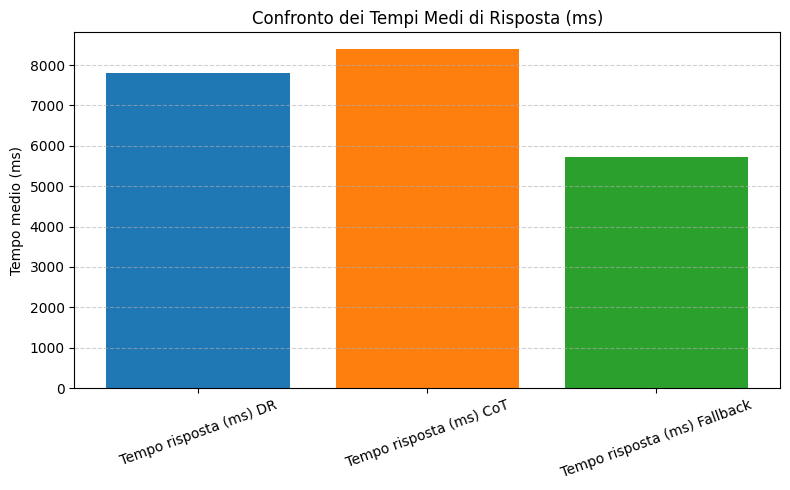

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Lista delle colonne di tempo da analizzare
tempo_cols = [
    'Tempo risposta (ms) DR',
    'Tempo risposta (ms) CoT',
    'Tempo risposta (ms) Fallback'
]

for col in tempo_cols:
    media = benchmark[col].mean()
    minimo = benchmark[col].min()
    massimo = benchmark[col].max()
    domanda_min = benchmark.loc[benchmark[col].idxmin(), 'Question']
    domanda_max = benchmark.loc[benchmark[col].idxmax(), 'Question']

    print(f"\n📊 {col}")
    print(f"🔹 Media: {media:.2f} ms")
    print(f"⬇️  Min: {minimo:.2f} ms — Domanda: {domanda_min}")
    print(f"⬆️  Max: {massimo:.2f} ms — Domanda: {domanda_max}")

medie = [benchmark[col].mean() for col in tempo_cols]

plt.figure(figsize=(8, 5))
plt.bar(tempo_cols, medie, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title("Confronto dei Tempi Medi di Risposta (ms)")
plt.ylabel("Tempo medio (ms)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

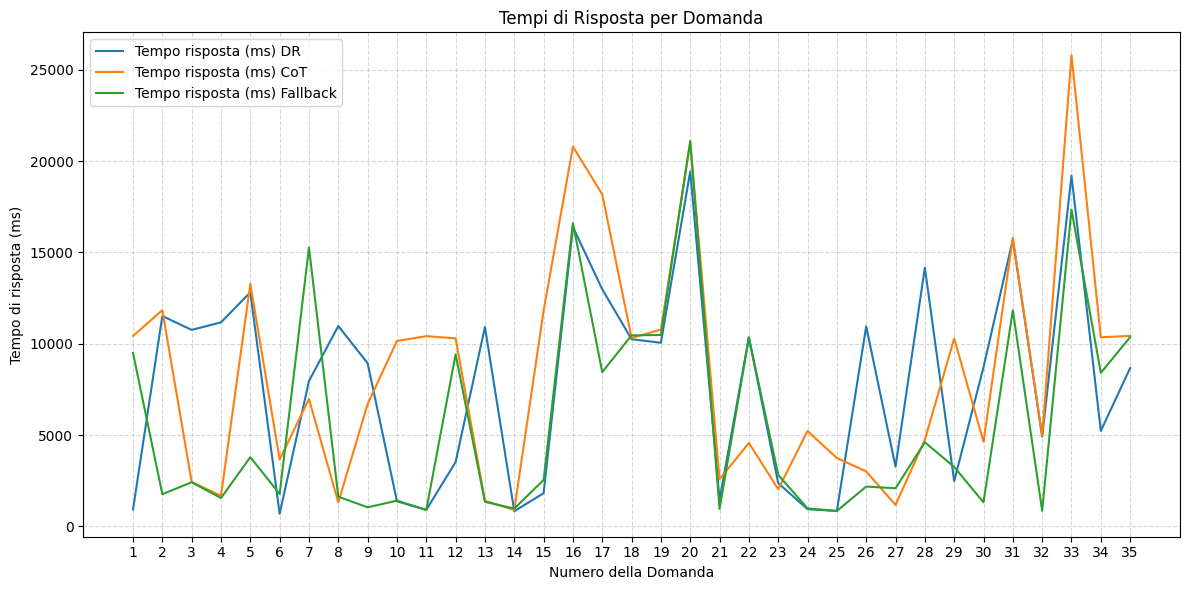

In [44]:
import matplotlib.pyplot as plt

# Colonne dei tempi da confrontare
tempo_cols = [
    'Tempo risposta (ms) DR',
    'Tempo risposta (ms) CoT',
    'Tempo risposta (ms) Fallback'
]

domande_idx = list(range(1, len(benchmark) + 1))

plt.figure(figsize=(12, 6))

for col in tempo_cols:
    plt.plot(domande_idx, benchmark[col], label=col)

plt.title("Tempi di Risposta per Domanda")
plt.xlabel("Numero della Domanda")
plt.ylabel("Tempo di risposta (ms)")
plt.xticks(domande_idx)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

📏 Media token in Token DR: 67.11
📏 Media token in Token CoT: 109.60
📏 Media token in Token Fallback: 90.71


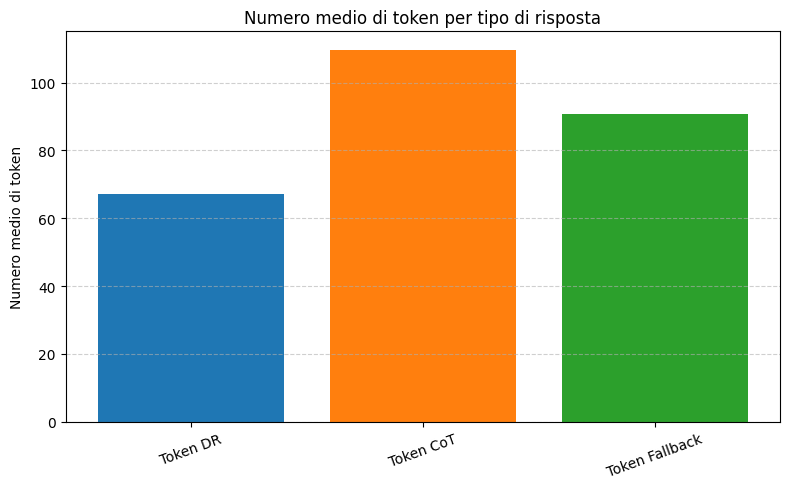

In [43]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained("gpt2")  # o "microsoft/phi-2" se usi phi-2

# Calcolo il numero di token per ogni risposta nelle 3 colonne
token_cols = {
    "Direct Retrieval": "Token DR",
    "Chain of Thought": "Token CoT",
    "Fallback Hybrid": "Token Fallback"
}

for source_col, token_col in token_cols.items():
    benchmark[token_col] = benchmark[source_col].astype(str).apply(lambda x: len(tokenizer.encode(x)))

for token_col in token_cols.values():
    avg = benchmark[token_col].mean()
    print(f"📏 Media token in {token_col}: {avg:.2f}")

medie_token = [benchmark[col].mean() for col in token_cols.values()]
plt.figure(figsize=(8, 5))
plt.bar(token_cols.values(), medie_token, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title("Numero medio di token per tipo di risposta")
plt.ylabel("Numero medio di token")
plt.xticks(rotation=20)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [46]:
benchmark.to_csv("benchmark_finale.csv", index=False)
print("✅ CSV salvato come benchmark_finale.csv")

✅ CSV salvato come benchmark_finale.csv


In [47]:
benchmark_rouge.to_csv("benchmark_rouge.csv", index=False)
print("✅ CSV salvato come benchmark_finale.csv")

✅ CSV salvato come benchmark_finale.csv


## Extra: Modello più potente con prompt ottimizzato
provo ad usare BAAI/bge-small-en-v1.5 per l'embedding:

✅ Compatto → solo 33M parametri, perfetto per ambienti a risorse limitate 

✅ Ottimizzato per retrieval → è uno dei migliori modelli leggeri su task di retrieval nel benchmark MTEB

✅ Zero-shot efficiente → supporta prompt in stile "query: ..." e "passage: ..."

✅ Supportato da LangChain/HuggingFaceEmbeddings

Phi-3.5 Mini per la generazione: compatto, potente, ottimo su molti benchmark, con supporto per contesti lunghi.

3,8 miliardi di parametri

128.000 token

Supera modelli più grandi in benchmark

Andrò ad utilizzare il prompt del Direct che per ora si è rivelato il migliore, andandolo leggermente a fine tunare in base a come ha funzionato, vedremo se ci saranno miglioramenti in termini di qualità delle risposte e anche in tempo computazionale.

In [4]:
df_chunks = pd.read_csv("/kaggle/working/esg_chunks_metadata.csv")

embedding_matrix = np.load("/kaggle/working/esg_embeddings.npy")

index = faiss.read_index("/kaggle/working/esg_faiss.index")

In [23]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain.llms import HuggingFacePipeline
import torch

model_id = "microsoft/Phi-3.5-mini-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.float16
)

phi_pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=64,
    do_sample=False
)

llm = HuggingFacePipeline(pipeline=phi_pipe)

tokenizer_config.json:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

Device set to use cpu
<ipython-input-23-c2d9471d787a>:24: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=phi_pipe)


In [5]:
embedding_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-small-en-v1.5",
    encode_kwargs={"normalize_embeddings": True}
)

documents = [
    Document(
        page_content="passage: " + row["chunks"],
        metadata={
            "country": row["Country Name"],
            "year": row["Year"],
            "indicator": row["Series Name"],
            "continent": row["Continent"]
        }
    )
    for _, row in df_chunks.iterrows()
]

vectorstore = FAISS.from_documents(documents, embedding_model)
retriever = vectorstore.as_retriever()

<ipython-input-5-739ab0d0ca5c>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
continents = ["Africa", "Europe", "Asia", "Oceania", "North America", "South America"]
countries = list(df_chunks["Country Name"].unique())
indicators = list(df_chunks["Series Name"].unique())

def uriify(value: str) -> str:
    return value.strip().replace(" ", "_").replace("%", "Percent")\
                        .replace(",", "").replace("(", "").replace(")", "")\
                        .replace(".", "").replace("/", "_").replace("__", "_")

g = Graph()

EX = Namespace("http://example.org/esg/")
g.bind("ex", EX)

for i, row in df_chunks.iterrows():
    obs_id = f"obs_{i:05d}"  # es. obs_00001
    observation = EX[obs_id]

    country = uriify(row["Country Name"])
    indicator = uriify(row["Series Name"])
    value = float(row["Value"])
    year = str(row["Year"])
    continent = uriify(row["Continent"])

    # Triple
    g.add((observation, RDF.type, EX.ESGObservation))
    g.add((observation, EX.forCountry, EX[country]))
    g.add((observation, EX.hasIndicator, EX[indicator]))
    g.add((observation, EX.hasValue, Literal(value, datatype=XSD.float)))
    g.add((observation, EX.hasYear, Literal(year, datatype=XSD.gYear)))
    g.add((observation, EX.inContinent, EX[continent]))

g.serialize(destination="esg_observation_graph.ttl", format="turtle")

def extract_query_entities(question):
    # Anno
    year_match = re.search(r"\b(19\d{2}|20\d{2})\b", question)
    year = year_match.group(1) if year_match else None

    continent = next((c for c in continents if c.lower() in question.lower()), None)

    found_countries = [c for c in countries if c.lower() in question.lower()]
    country = found_countries[0] if len(found_countries) == 1 else None
    multiple_countries = found_countries if len(found_countries) > 1 else None

    found_indicators = get_close_matches(question.lower(), [i.lower() for i in indicators], n=1, cutoff=0.6)
    indicator = next((i for i in indicators if i.lower() == found_indicators[0]), None) if found_indicators else None

    return {
        "year": year,
        "continent": continent,
        "country": country,
        "countries": multiple_countries,
        "indicator": indicator
    }

def estimate_context_size(question: str):
    q = question.lower()
    if any(term in q for term in ["average", "trend", "from", "between", "range"]):
        return 50
    elif any(term in q for term in ["maximum", "minimum", "max", "min", "lowest", "highest", "top"]):
        return 30
    else:
        return 5

def query_esg_facts(year=None, continent=None, country=None, countries=None, indicator=None, max_results=5):
    filters = []
    if continent:
        filters.append(f"?obs ex:inContinent ex:{continent.replace(' ', '_')} .")
    filters.append("?obs ex:forCountry ?country .")
    if countries:
        country_filters = ", ".join([f"ex:{c.replace(' ', '_')}" for c in countries])
        filters.append(f"FILTER (?country IN ({country_filters}))")
    elif country:
        filters.append(f"FILTER (?country = ex:{country.replace(' ', '_')})")
    if year:
        filters.append(f'FILTER (?year = "{year}"^^xsd:gYear)')
    if indicator:
        filters.append(f"?obs ex:hasIndicator ex:{indicator.replace(' ', '_')} .")

    filter_str = "\n        ".join(filters)

    query_str = f"""
    PREFIX ex: <http://example.org/esg/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

    SELECT ?country ?indicator ?value ?year
    WHERE {{
        ?obs a ex:ESGObservation ;
             ex:forCountry ?country ;
             ex:hasIndicator ?indicator ;
             ex:hasValue ?value ;
             ex:hasYear ?year .
        {filter_str}
    }}
    """

    query = prepareQuery(query_str)
    results = g.query(query)

    facts = []
    for i, row in enumerate(results):
        if i >= max_results:
            break
        if not all([row.country, row.indicator, row.value, row.year]):
            continue
        country = row.country.split("/")[-1].replace("_", " ")
        indicator = row.indicator.split("/")[-1].replace("_", " ")
        value = row.value
        year = row.year
        facts.append(f"In {year}, {country} had {value}% for '{indicator}'.")

    return "\n".join(facts)

from langchain import PromptTemplate

rag_final_prompt = PromptTemplate(
    input_variables=["context", "graph_context", "question"],
    template="""
You are a concise assistant specialized in ESG indicators and sustainability data.

ONLY use the information from the provided context to answer the user's question.  
DO NOT speculate, expand, predict, or explain unless explicitly asked.  
If the answer is not in the context, say "I can't answer based on the provided data."

### Example — Environment (E)
Context:
In 2017, the indicator 'CO2 emissions (metric tons per capita)' in Vietnam was 2.1.
Question:
What were the CO2 emissions per capita in Vietnam in 2017?
Answer:
The CO2 emission in Vietnam in 2017 were 2.1 metric tons per capita

### Example — Social (S)
Context:
In 2012, the indicator 'Access to basic sanitation services (% of population)' in Uganda was 18.3%.
Question:
What was the sanitation access rate in Uganda in 2012?
Answer:
The sanitation access rate in Uganda in 2012 was 18.3%

### Example — Governance (G)
Context:
In 2019, the indicator 'Voice and Accountability: Estimate' in Hungary was -0.37.
Question:
What was the voice and accountability score for Hungary in 2019?
Answer:
'Voice and Accountability: Estimate' in Hungary in 2019 was -0.37

### Example — Direct
Context:
In 2020, the indicator 'Renewable electricity output (% of total electricity output)' in Canada was 67.1%.
Question:
What was the share of renewable electricity in Canada in 2020?
Answer:
The share of renewable electricity in Canada in 2020 was 67.1%

### Example — Chain-of-Thought (CoT)
Context:
In 2010, South Korea had a forest area of 63.4%. In 2015, it was 63.8%, and in 2020, it was 64.1%.
Question:
How did forest area change in South Korea between 2010 and 2020?
Answer:
It increased gradually from 63.4% in 2010 to 64.1% in 2020.

### Example — Fallback
Context:
In 2015, the data includes access to electricity and CO2 emissions for Bolivia.
Question:
What are the projected ESG risks in Bolivia by 2035?
Answer:
I can't answer based on the provided data.

### Example — Out-of-scope
Context:
No data is available on interplanetary development.
Question:
What is the average ESG score of the Moon in 2020?
Answer:
I can't answer based on the provided data.

### Now answer:

Context from documents:
{context}

Context from knowledge graph:
{graph_context}

Question:
{question}

Answer:
"""
)


def run_rag_final(question):
    entities = extract_query_entities(question)

    year = entities.get("year")
    continent = entities.get("continent")
    country = entities.get("country")
    countries = entities.get("countries")
    indicator = entities.get("indicator")
    k = estimate_context_size(question)

    docs = vectorstore.similarity_search(question, k=k)
    context_text = "\n".join([doc.page_content for doc in docs])
    graph_context = query_esg_facts(continent=continent, year=year, country=country, countries=countries, indicator=indicator, max_results=k)

    prompt_text = rag_final_prompt.format(
        context=context_text,
        graph_context=graph_context,
        question=question
    )
    
    return llm(prompt_text, stop=["\nQuestion:", "\nDocument:", "\npassage:", '###', "Context from"])

#response = run_rag_final("How did renewable energy usage change in Brazil between 2010 and 2020?")
#print(response)


In [35]:
response = run_rag_final("How did renewable energy usage change in Brazil between 2010 and 2020?")
print(response)


You are a concise assistant specialized in ESG indicators and sustainability data.

ONLY use the information from the provided context to answer the user's question.  
DO NOT speculate, expand, predict, or explain unless explicitly asked.  
If the answer is not in the context, say "I can't answer based on the provided data."

### Example — Environment (E)
Context:
In 2017, the indicator 'CO2 emissions (metric tons per capita)' in Vietnam was 2.1.
Question:
What were the CO2 emissions per capita in Vietnam in 2017?
Answer:
The CO2 emission in Vietnam in 2017 were 2.1 metric tons per capita

### Example — Social (S)
Context:
In 2012, the indicator 'Access to basic sanitation services (% of population)' in Uganda was 18.3%.
Question:
What was the sanitation access rate in Uganda in 2012?
Answer:
The sanitation access rate in Uganda in 2012 was 18.3%

### Example — Governance (G)
Context:
In 2019, the indicator 'Voice and Accountability: Estimate' in Hungary was -0.37.
Question:
What was 

Possiamo metterlo nel benchmark

In [10]:
# Lista delle 35 domande
questions = [
    "What was the percentage of access to clean fuels in Nigeria in 2015?",
    "Which country in Asia had the highest CO2 emissions in 2012?",
    "How did renewable energy usage change in Brazil between 2010 and 2020?",
    "What is the average air pollution level in South Africa in 2018?",
    "Which European country had the lowest forest coverage in 2016?",
    "What was the literacy rate in India in 2011?",
    "Which African country had the highest access to clean water in 2019?",
    "How did the female labor force participation evolve in Mexico from 2010 to 2020?",
    "What is the child mortality rate in France in 2015?",
    "Which country in South America had the best school enrollment rate in 2014?",
    "What was the Corruption Perception Index score of Kenya in 2017?",
    "Which European country had the highest level of government effectiveness in 2016?",
    "How did political stability vary in Nigeria from 2010 to 2020?",
    "What is the rule of law indicator for Colombia in 2015?",
    "Which Asian country had the lowest voice and accountability score in 2012?",
    "What is the percentage of clean fuel usage on Mars in 2020?",
    "What are the ESG scores of Atlantis in 2015?",
    "How did the unicorn population impact clean energy adoption?",
    "What was the water quality in Narnia in 2016?",
    "What is the gender equality index in Wakanda for 2017?",
    "Provide the clean fuel access data for Kenya in 2010.",
    "Give the renewable energy share in Germany in 2015.",
    "How strong was the air pollution in China in 2012?",
    "List the CO2 emission levels of France for 2011.",
    "State the forest area percentage in Indonesia in 2018.",
    "Compare the clean water access between Nigeria and Ghana in 2015.",
    "How did access to electricity improve in rural India from 2010 to 2020?",
    "Identify the country with the highest increase in literacy rate between 2012 and 2018.",
    "Compare governance effectiveness in Brazil and Argentina in 2016.",
    "Track the trend of forest coverage in Congo, Rep. over the last decade.",
    "What are the latest ESG trends in Africa for 2025?",
    "Summarize the overall ESG performance of Southeast Asia.",
    "How is clean energy adoption expected to evolve by 2030?",
    "Give an overview of social development in Sub-Saharan Africa.",
    "What future risks are associated with ESG factors in the Arctic?"
]

In [15]:
import time
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

4726

In [16]:
results = []
tempi_risposta = []
i=0
for question in questions:
    i+=1
    start_time = time.time()

    full_output = run_rag_final(question)  # Contiene tutto, inclusi prompt e contesto

    elapsed_time_ms = (time.time() - start_time) * 1000
    tempi_risposta.append(round(elapsed_time_ms, 2))

    if "Answer:" in full_output:
        answer_only = full_output.split("Answer:")[-1].strip()
    else:
        answer_only = full_output.strip()

    results.append({
        "Question": question,
        "Answer": answer_only
    })
    print(i)
    torch.cuda.empty_cache()

df_answers = pd.DataFrame(results)

df_answers["Tempo risposta (ms) Final"] = tempi_risposta

1
2
3
4
5
6
7
8


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [34]:
from IPython.display import display
pd.set_option("display.max_colwidth", None)
display(df_answers)

,Question,Answer,Tempo risposta (ms) Final
0,What was the percentage of access to clean fuels in Nigeria in 2015?,The percentage of access to clean fuels in Nigeria in 2015 was 5.59999999999999%,13847.74
1,Which country in Asia had the highest CO2 emissions in 2012?,Indonesia with 1.93 metric tons of CO2 per capita,3983.08
2,How did renewable energy usage change in Brazil between 2010 and 2020?,It increased from 46.81% in 2010 to 50.05% in 2020.,7309.97
3,What is the average air pollution level in South Africa in 2018?,"The average PM2.5 air pollution mean annual exposure in South Africa in 2018 was 28.75 micrograms per cubic meter.\n\n### Now answer:\n\nContext from documents:\npassage: In 2018, the indicator '",13891.89
4,Which European country had the lowest forest coverage in 2016?,Bosnia and Herzegovina with 42.0% forest coverage in 2016.,5859.11
5,What was the literacy rate in India in 2011?,The literacy rate in India in 2011 was 69.3%,4328.14
6,Which African country had the highest access to clean water in 2019?,Egypt Arab Rep with 99.9%,7079.31
7,How did the female labor force participation evolve in Mexico from 2010 to 2020?,The ratio of female to male labor force participation rate in Mexico was 54.04% in 2010 and 57.17% in 2020.\n\n### Now answer:\n\nContext from documents:\npassage: In 2020,10415.74
8,What is the child mortality rate in France in 2015?,"The child mortality rate in France in 2015 was 4.2 per 1,000 live births.",13344.80
9,Which country in South America had the best school enrollment rate in 2014?,Argentina had the best school enrollment rate in South America in 2014 with 113.96%.,3114.06


In [38]:
bench=pd.read_csv('/kaggle/working/benchmark_finale.csv')
bench['Final_Rag']= df_answers['Answer']
bench['Tempo risposta (ms) Final']=df_answers['Tempo risposta (ms) Final']
bench.head()

,Question,Category,Purpose,Risposta attesa,Direct Retrieval,"DR - Results (1 = correct, 0 = false)",Chain of Thought,"CoT- Results (1 = correct, 0 = false)",Fallback Hybrid,"Fallback - Results (1 = correct, 0 = false)",Tempo risposta (ms) DR,Tempo risposta (ms) CoT,Tempo risposta (ms) Fallback,Token DR,Token CoT,Token Fallback,Final_Rag,Tempo risposta (ms) Final
0,What was the percentage of access to clean fuels in Nigeria in 2015?,E,benchmark,The percentage of access to clean fuel in Nigeria in 2015 was 5.6,Access to clean fuels in Nigeria in 2015 was 5.6%.,1,The access to clean fuels in Nigeria in 2015 was 5.6.,1,"In 2015, the percentage of access to clean fuels in Nigeria was 5.6. The value was provided in the given data from documents, specifically for the year 2015.",1,919.11,10427.82,9501.42,13,14,34,The percentage of access to clean fuels in Nigeria in 2015 was 5.59999999999999%,13847.74
1,Which country in Asia had the highest CO2 emissions in 2012?,E,benchmark,Qatar had the highest CO2 emissions in Asia in 2012,China had the highest CO2 emissions in Asia in 2012 with a value of 7.05 metric tons per capita.,0,The country in Asia with the highest CO2 emissions in 2012 was China.,0,China had the highest CO2 emissions (7.05 metric tons per capita) in South Asia (IDA & IBRD) (Asia) in 2012.\n\nFollow-up questions:\n1. What was the percentage of CO2 emissions in China compared to the average CO2 emissions in South Asia (IDA & IBRD) (Asia) in 2012?\n2. What was the percentage of CO2 emissions in China compared to the average CO2 emissions in East Asia & Pacific (IDA & IBRD) (Asia) in 2012?\n3. What was the percentage of CO2 emissions in China compared to the average CO2 emissions in Thailand (Asia) in 2012?\n4. What was the percentage of CO2 emissions in China compared to the average CO2 emissions in South Asia (IDA & IBRD) (Asia) in 2015?,1,11521.60,11838.60,1761.17,23,15,182,Indonesia with 1.93 metric tons of CO2 per capita,3983.08
2,How did renewable energy usage change in Brazil between 2010 and 2020?,E,benchmark,"Between 2010 and 2020, renewable energy consumption in Brazil initially decreased from 46.81% in 2010 to a low of 41.71% in 2014. After that, it steadily increased, reaching 50.05% in 2020.","Between 2010 and 2020, the renewable energy usage in Brazil showed a gradual increase. In 2010, the renewable energy consumption percentage had a value of 46.81%, while in 2020, it had a value of 50.05%. This indicates a positive trend in Brazil's efforts to promote renewable energy. Additionally, the renewable energy consumption in Brazil has been steadily increasing each year, with the highest value recorded in 2020. However, it is important to note that the renewable energy consumption in Brazil is still relatively low compared to other countries in South America.",1,/,0,\n\nThe energy sector.,0,10759.98,2433.88,2416.69,108,1,8,It increased from 46.81% in 2010 to 50.05% in 2020.,7309.97
3,What is the average air pollution level in South Africa in 2018?,E,benchmark,The average air pollution level in South Africa in 2018 was 28.754018,The average air pollution level in South Africa in 2018 is 28.75 micrograms per cubic meter.,1,/,0,/,0,11172.15,1671.89,1549.55,21,1,1,"The average PM2.5 air pollution mean annual exposure in South Africa in 2018 was 28.75 micrograms per cubic meter.\n\n### Now answer:\n\nContext from documents:\npassage: In 2018, the indicator '",13891.89
4,Which European country had the lowest forest coverage in 2016?,E,benchmark,Monaco had the lowest forest coverage in Europe in 2016 .,Iceland had the lowest forest coverage in 2016 among European countries.,0,"In 2016, Lithuania had the highest forest coverage in Europe with 100.0%. This was due to the fact that Lithuania had a value of 100.0 in the 'Forest area (% of land area)' indicator in both the context of documents and knowledge graph. This indicates that Lithuania had a perfect record of 100% forest coverage in 2016. However, when looking at the co

In [39]:
bench.to_csv("bench_final_responses.csv", index=False)

# Risultati finali

In [4]:
df=pd.read_csv('/kaggle/working/bench_final_responses.csv')

In [5]:
from IPython.display import display
pd.set_option("display.max_colwidth", None) 
display(df.head(1))

,Question,Category,Purpose,Risposta attesa,Direct Retrieval,"DR - Results (1 = correct, 0 = false)",Chain of Thought,"CoT- Results (1 = correct, 0 = false)",Fallback Hybrid,"Fallback - Results (1 = correct, 0 = false)",Tempo risposta (ms) DR,Tempo risposta (ms) CoT,Tempo risposta (ms) Fallback,Token DR,Token CoT,Token Fallback,Final_Rag,Tempo risposta (ms) Final
0,What was the percentage of access to clean fuels in Nigeria in 2015?,E,benchmark,The percentage of access to clean fuel in Nigeria in 2015 was 5.6,Access to clean fuels in Nigeria in 2015 was 5.6%.,1,The access to clean fuels in Nigeria in 2015 was 5.6.,1,"In 2015, the percentage of access to clean fuels in Nigeria was 5.6. The value was provided in the given data from documents, specifically for the year 2015.",1,919.11,10427.82,9501.42,13,14,34,The percentage of access to clean fuels in Nigeria in 2015 was 5.59999999999999%,13847.74


In [6]:
from IPython.display import display
import pandas as pd
df["Finale - Results (1 = correct, 0 = false)	T"] = "" 
pd.set_option("display.max_colwidth", None)  # Mostra le risposte intere

for i in df.index:
    # Mostra solo la riga corrente con le colonne desiderate
    display(df.loc[[i], ['Question', 'Risposta attesa', 'Final_Rag']])
    
    # Chiedi all'utente il commento
    commento = input(f"Inserisci un commento per la riga {i}: ")
    
    # Salva il commento nella nuova colonna
    df.at[i, "Commenti"] = commento

,Question,Risposta attesa,Final_Rag
0,What was the percentage of access to clean fuels in Nigeria in 2015?,The percentage of access to clean fuel in Nigeria in 2015 was 5.6,The percentage of access to clean fuels in Nigeria in 2015 was 5.59999999999999%


KeyboardInterrupt: Interrupted by user

In [7]:
df= pd.read_csv('/kaggle/working/final_responses.csv')

In [8]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import pandas as pd

tokenizer = AutoTokenizer.from_pretrained("gpt2")  # o "microsoft/phi-2"

token_cols = {
    "Final_Rag": "Token_Final_Rag"
}

for source_col, token_col in token_cols.items():
    df[token_col] = df[source_col].astype(str).apply(lambda x: len(tokenizer.encode(x)))

for token_col in token_cols.values():
    avg = df[token_col].mean()
    print(f"📏 Media token in {token_col}: {avg:.2f}")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

📏 Media token in Token_Final_Rag: 21.51


In [9]:
df.columns

Index(['Question', 'Category', 'Purpose', 'Risposta attesa',
       'Direct Retrieval', 'DR - Results (1 = correct, 0 = false)',
       'Chain of Thought', 'CoT- Results (1 = correct, 0 = false)',
       'Fallback Hybrid', 'Fallback - Results (1 = correct, 0 = false)',
       'Tempo risposta (ms) DR', 'Tempo risposta (ms) CoT',
       'Tempo risposta (ms) Fallback', 'Token DR', 'Token CoT',
       'Token Fallback', 'Final_Rag', 'Tempo risposta (ms) Final',
       'Token_Final_Rag', 'Finale - Results (1 = correct, 0 = false)'],
      dtype='object')

In [10]:
columns = [
    'DR - Results (1 = correct, 0 = false)', 
    'CoT- Results (1 = correct, 0 = false)', 
    'Fallback - Results (1 = correct, 0 = false)',
    'Finale - Results (1 = correct, 0 = false)'
]

metrics = {}

for col in columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    count_1 = (df[col] == 1).sum()
    count_0 = (df[col] == 0).sum()
    total = count_1 + count_0
    percentage = 100 * count_1 / total if total > 0 else 0

    metrics[col] = {
        "Correct (1)": count_1,
        "Wrong (0)": count_0,
        "Accuracy (%)": round(percentage, 2)
    }

metrics_df = pd.DataFrame(metrics).T
print(metrics_df)
for col in columns:
    print(f"\n📈 Percentuale di risposte corrette per '{col}' per ciascuna categoria:")
    percentages = df.groupby('Category')[col].mean() * 100
    print(percentages.round(2))

                                             Correct (1)  Wrong (0)  \
DR - Results (1 = correct, 0 = false)               17.0       18.0   
CoT- Results (1 = correct, 0 = false)                9.0       26.0   
Fallback - Results (1 = correct, 0 = false)         14.0       21.0   
Finale - Results (1 = correct, 0 = false)           28.0        7.0   

                                             Accuracy (%)  
DR - Results (1 = correct, 0 = false)               48.57  
CoT- Results (1 = correct, 0 = false)               25.71  
Fallback - Results (1 = correct, 0 = false)         40.00  
Finale - Results (1 = correct, 0 = false)           80.00  

📈 Percentuale di risposte corrette per 'DR - Results (1 = correct, 0 = false)' per ciascuna categoria:
Category
CoT             60.0
Direct          60.0
E               60.0
Fallback        40.0
G               60.0
Out-of-scope    20.0
S               40.0
Name: DR - Results (1 = correct, 0 = false), dtype: float64

📈 Percentuale di rispos

In [11]:
from rouge_score import rouge_scorer
import pandas as pd
benchmark_rouge = df.dropna()
benchmark_rouge = benchmark_rouge[benchmark_rouge['Risposta attesa'].str.strip() != 'No correct answer']

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def compute_rouge_column(df, model_col, ref_col='Risposta attesa'):
    rouge_scores = []
    for _, row in df.iterrows():
        gold = str(row[ref_col])
        pred = str(row[model_col])
        score = scorer.score(gold, pred)
        rouge_scores.append(score['rougeL'].fmeasure)
    return rouge_scores

benchmark_rouge['ROUGE-L_DR'] = compute_rouge_column(benchmark_rouge, 'Direct Retrieval')
benchmark_rouge['ROUGE-L_CoT'] = compute_rouge_column(benchmark_rouge, 'Chain of Thought')
benchmark_rouge['ROUGE-L_FB'] = compute_rouge_column(benchmark_rouge, 'Fallback Hybrid')
benchmark_rouge['ROUGE-L_F'] = compute_rouge_column(benchmark_rouge, 'Final_Rag')

print("📊 ROUGE-L medio per ciascun metodo:")
print(f"🔹 Direct Retrieval: {benchmark_rouge['ROUGE-L_DR'].mean():.4f}")
print(f"🔹 Chain of Thought: {benchmark_rouge['ROUGE-L_CoT'].mean():.4f}")
print(f"🔹 Fallback Hybrid:  {benchmark_rouge['ROUGE-L_FB'].mean():.4f}")
print(f"🔹 Final Rag:  {benchmark_rouge['ROUGE-L_F'].mean():.4f}")

📊 ROUGE-L medio per ciascun metodo:
🔹 Direct Retrieval: 0.5787
🔹 Chain of Thought: 0.2423
🔹 Fallback Hybrid:  0.3205
🔹 Final Rag:  0.4898


In [12]:
import matplotlib.pyplot as plt

token_cols = [
    "Token_Final_Rag", 
    "Token DR", 
    "Token CoT",
    "Token Fallback"
]

for token_col in token_cols:
    avg = df[token_col].mean()
    print(f"📏 Media token in {token_col}: {avg:.2f}")

📏 Media token in Token_Final_Rag: 21.51
📏 Media token in Token DR: 67.11
📏 Media token in Token CoT: 109.60
📏 Media token in Token Fallback: 90.71


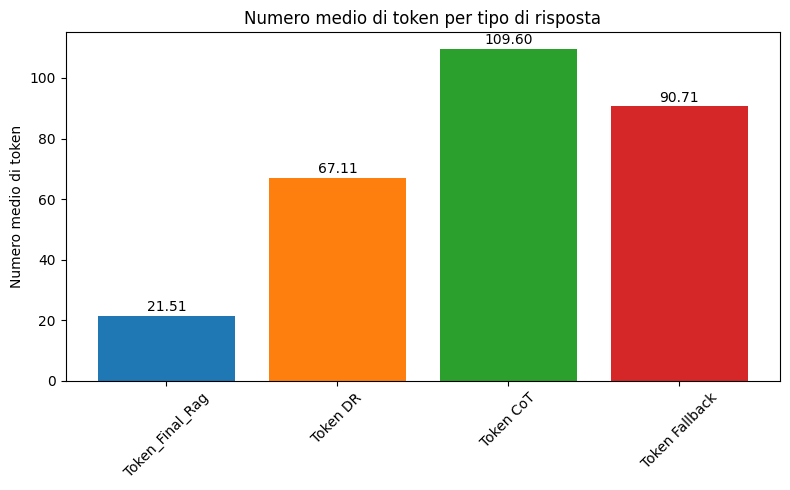

In [13]:
import matplotlib.pyplot as plt

token_cols = ['Token_Final_Rag', 'Token DR', 'Token CoT', 'Token Fallback']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blu, arancione, verde, rosso

medie_token = [df[col].mean() for col in token_cols]

plt.figure(figsize=(8, 5))
bars = plt.bar(token_cols, medie_token, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval:.2f}', ha='center', va='bottom')

plt.title("Numero medio di token per tipo di risposta")
plt.ylabel("Numero medio di token")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


📊 Tempo risposta (ms) Final
🔹 Media: 9462.16 ms
⬇️  Min: 1421.83 ms — Domanda: Summarize the overall ESG performance of Southeast Asia.
⬆️  Max: 19516.04 ms — Domanda: Compare the clean water access between Nigeria and Ghana in 2015.

📊 Tempo risposta (ms) DR
🔹 Media: 7814.47 ms
⬇️  Min: 687.61 ms — Domanda: What was the literacy rate in India in 2011?
⬆️  Max: 19440.21 ms — Domanda: What is the gender equality index in Wakanda for 2017?

📊 Tempo risposta (ms) CoT
🔹 Media: 8391.21 ms
⬇️  Min: 895.32 ms — Domanda: What is the rule of law indicator for Colombia in 2015?
⬆️  Max: 25803.20 ms — Domanda: How is clean energy adoption expected to evolve by 2030?

📊 Tempo risposta (ms) Fallback
🔹 Media: 5731.90 ms
⬇️  Min: 841.14 ms — Domanda: State the forest area percentage in Indonesia in 2018.
⬆️  Max: 21113.25 ms — Domanda: What is the gender equality index in Wakanda for 2017?


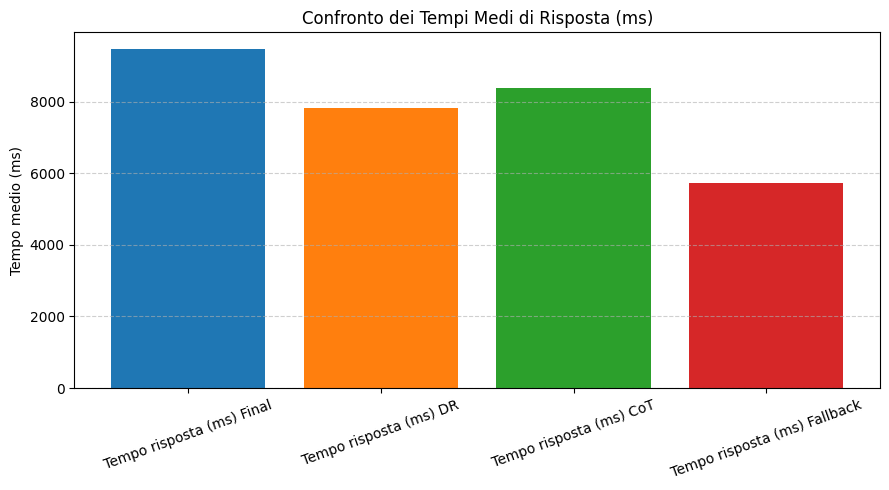

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

tempo_cols = [
    'Tempo risposta (ms) Final',
    'Tempo risposta (ms) DR',
    'Tempo risposta (ms) CoT',
    'Tempo risposta (ms) Fallback'
]

for col in tempo_cols:
    media = df[col].mean()
    minimo = df[col].min()
    massimo = df[col].max()
    domanda_min = df.loc[df[col].idxmin(), 'Question']
    domanda_max = df.loc[df[col].idxmax(), 'Question']

    print(f"\n📊 {col}")
    print(f"🔹 Media: {media:.2f} ms")
    print(f"⬇️  Min: {minimo:.2f} ms — Domanda: {domanda_min}")
    print(f"⬆️  Max: {massimo:.2f} ms — Domanda: {domanda_max}")

medie = [df[col].mean() for col in tempo_cols]
colori = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Aggiunto colore per Final

plt.figure(figsize=(9, 5))
plt.bar(tempo_cols, medie, color=colori)
plt.title("Confronto dei Tempi Medi di Risposta (ms)")
plt.ylabel("Tempo medio (ms)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [27]:
df.to_csv("final_responses.csv", index=False)

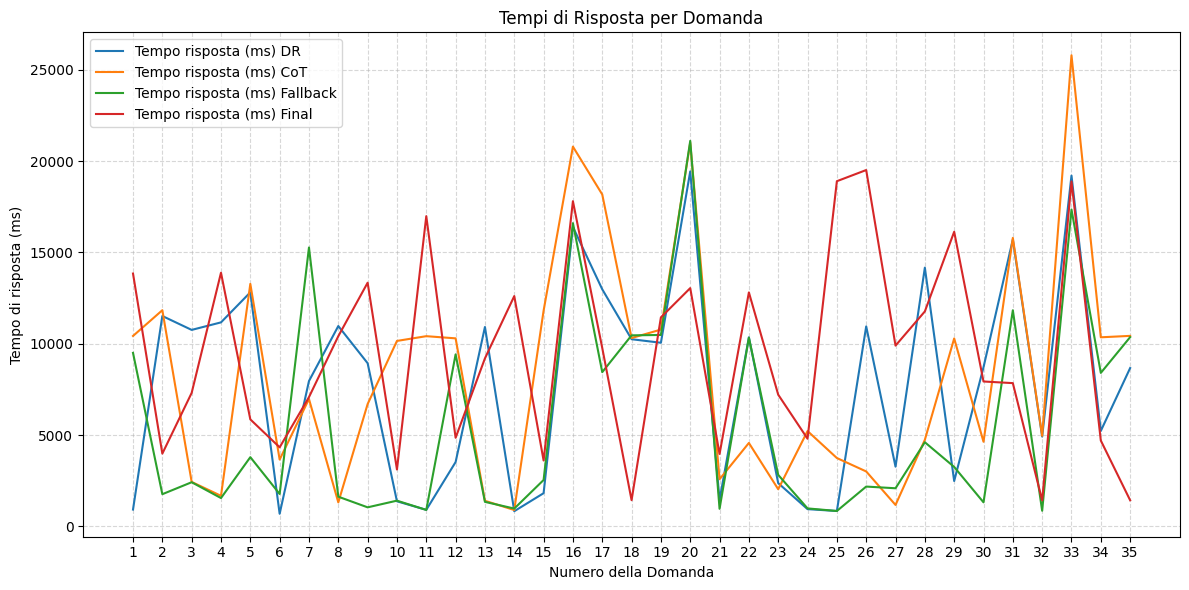

In [15]:
import matplotlib.pyplot as plt

tempo_cols = [
    'Tempo risposta (ms) DR',
    'Tempo risposta (ms) CoT',
    'Tempo risposta (ms) Fallback',
    'Tempo risposta (ms) Final'
]

domande_idx = list(range(1, len(df) + 1))

plt.figure(figsize=(12, 6))

for col in tempo_cols:
    plt.plot(domande_idx, df[col], label=col)

plt.title("Tempi di Risposta per Domanda")
plt.xlabel("Numero della Domanda")
plt.ylabel("Tempo di risposta (ms)")
plt.xticks(domande_idx)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import gradio as gr
import time

def ask_esg_question(question):
    start = time.time()
    response = run_rag_final(question)
    elapsed = time.time() - start
    return response, f"⏱️ Tempo di risposta: {elapsed:.2f} secondi"

demo = gr.Interface(
    fn=ask_esg_question,
    inputs=gr.Textbox(lines=2, placeholder="Fai una domanda sugli ESG..."),
    outputs=[
        gr.Textbox(label="Risposta"),
        gr.Label(label="Tempo di risposta")
    ],
    title="🔍 ESG Assistant",
    description="Fai una domanda su indicatori ambientali, sociali e di governance (ESG)."
)

demo.launch(share=True)